# Project 9: Partial Correlations and Directed Acyclic Graphs

The OLS regression is a powerful tool. So powerful, in fact, that you would have trouble mastering the tool in the period of just a few years. This is not to say that you could not master a particular application with OLS, however, there are many applications.

Statisticians have, historically, not been fond of making causal claims using statistics aside from the causal inferences generated from randomized control trials. In recent decades, however, the statisticians behind the causal inference revolution have move precisely in this direction. In this lesson, we will consider a particular manifestation of the causal inference revolution: Directed Acyclic Graphs (DAGs). DAGs provide a causal map, creating a causal skeleton detected using computational methods.

By graphically representing our models, we can represent common cases where causation is intermediated by the structure of data generating processes.

## Chains

Suppose that there exists three variables, $X$, $Y$, and $Z$ subject to the following structure: $X \rightarrow Y \rightarrow Z$.

Text(0.5, 1.0, 'Chain')

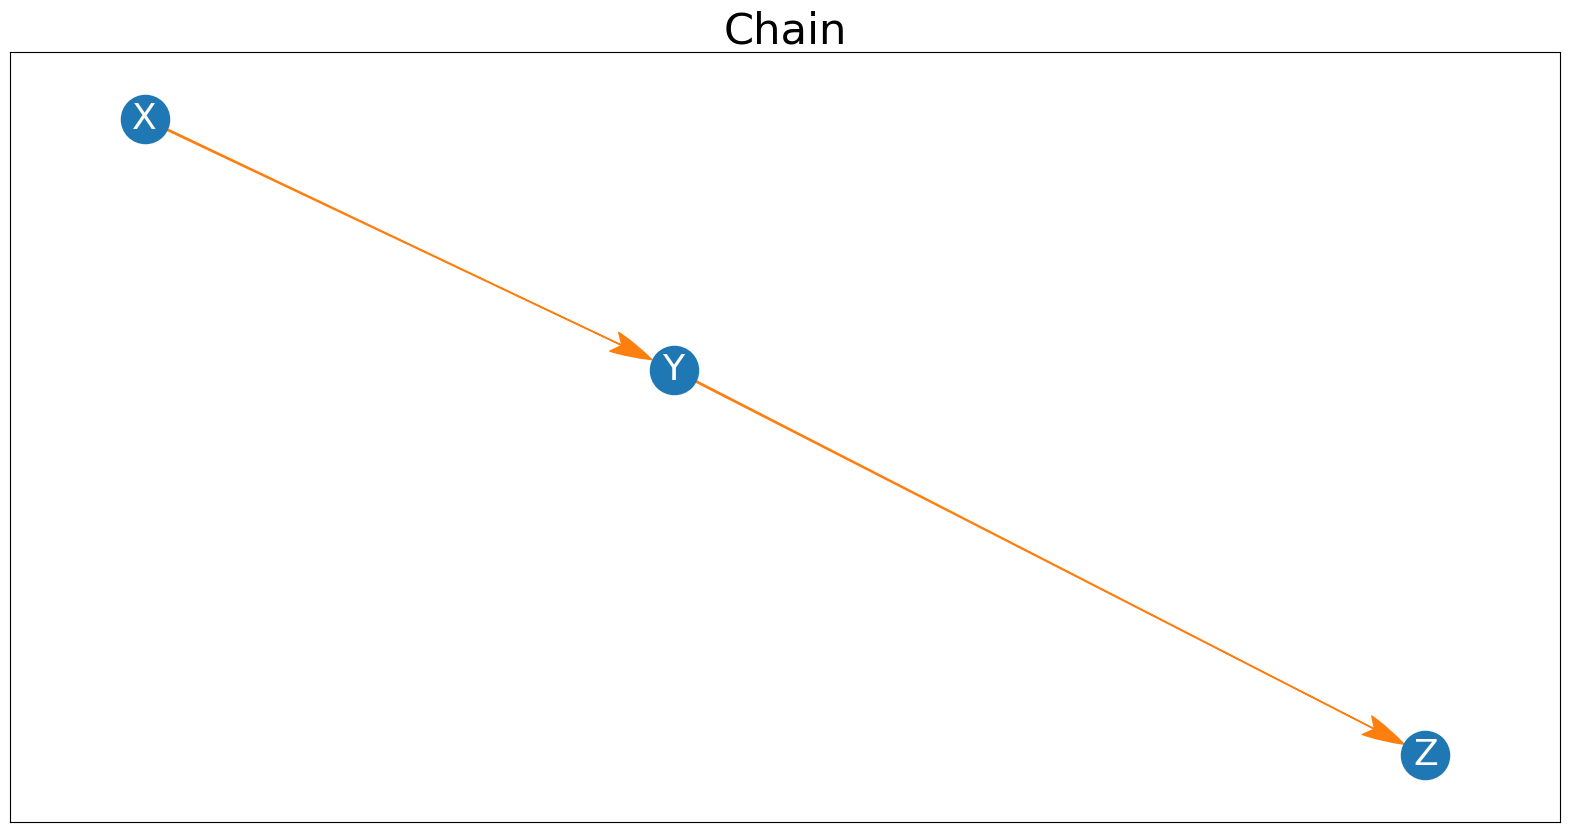

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
plt.rcParams.update({"font.size":26})
G = nx.DiGraph()
G.add_edges_from([("X","Y"),("Y","Z")])
pos = nx.spring_layout(G)#, k = 5/(len(sig_corr.keys())**.5))

fig,ax  = plt.subplots(figsize = (20,10))
# plt.title(title, fontsize = 30)
nx.draw_networkx(G, pos,node_size = 1200,
     with_labels=True,  arrows=True,
     font_color = "white",
     font_size = 26, alpha = 1,
     width = 1, edge_color = "C1",
     arrowstyle=ArrowStyle(
         "Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                ax = ax)
ax.set_title("Chain")

We can easily create variables following this structure. We will attempt to tease out this causal structure using the analytical tools that we have so far acquired.

In [2]:
import random
import numpy as np
import pandas as pd
length = 100000
cols = ["X", "Y", "Z"]
chain = {col:[] for col in cols}
for i in range(length):
    chain["X"].append(np.random.normal(0, 1))
    chain["Y"].append(chain["X"][-1] * -1 + np.random.normal(0, 2))
    chain["Z"].append(chain["Y"][-1] * .5 + np.random.normal(0, 1))
chain = pd.DataFrame(chain)
chain

X         Y         Z
0     -0.121568  1.333793 -0.078843
1      0.265097 -3.085944 -0.365651
2     -0.428946  4.068298  2.965343
3     -2.396553  2.256905  1.608411
4     -1.005944  3.907175  1.930520
...         ...       ...       ...
99995  1.860397 -0.726939 -1.348955
99996 -0.104266 -0.328269  1.238455
99997  1.245356 -1.760184  0.543223
99998  0.512521 -3.240289 -3.333125
99999  1.170441 -4.034745 -2.069463

[100000 rows x 3 columns]

Since $Z$ is a function of $Y$, and $Y$ is a function of $X$, all three variables are highly correlated. As we know the data gerating processes for these variables, we can meaningfully investigate the structure of these correlations.

In [3]:
chain.corr()

X         Y         Z
X  1.000000 -0.448758 -0.332990
Y -0.448758  1.000000  0.744134
Z -0.332990  0.744134  1.000000

C:\Users\JLCat\githubrepositories\Learn-Python-for-Stats-and-Econ\In Class Projects\datlib\plots.py:120: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(data, c = c, alpha = alpha, s = 200 / num_vars, ax=ax)


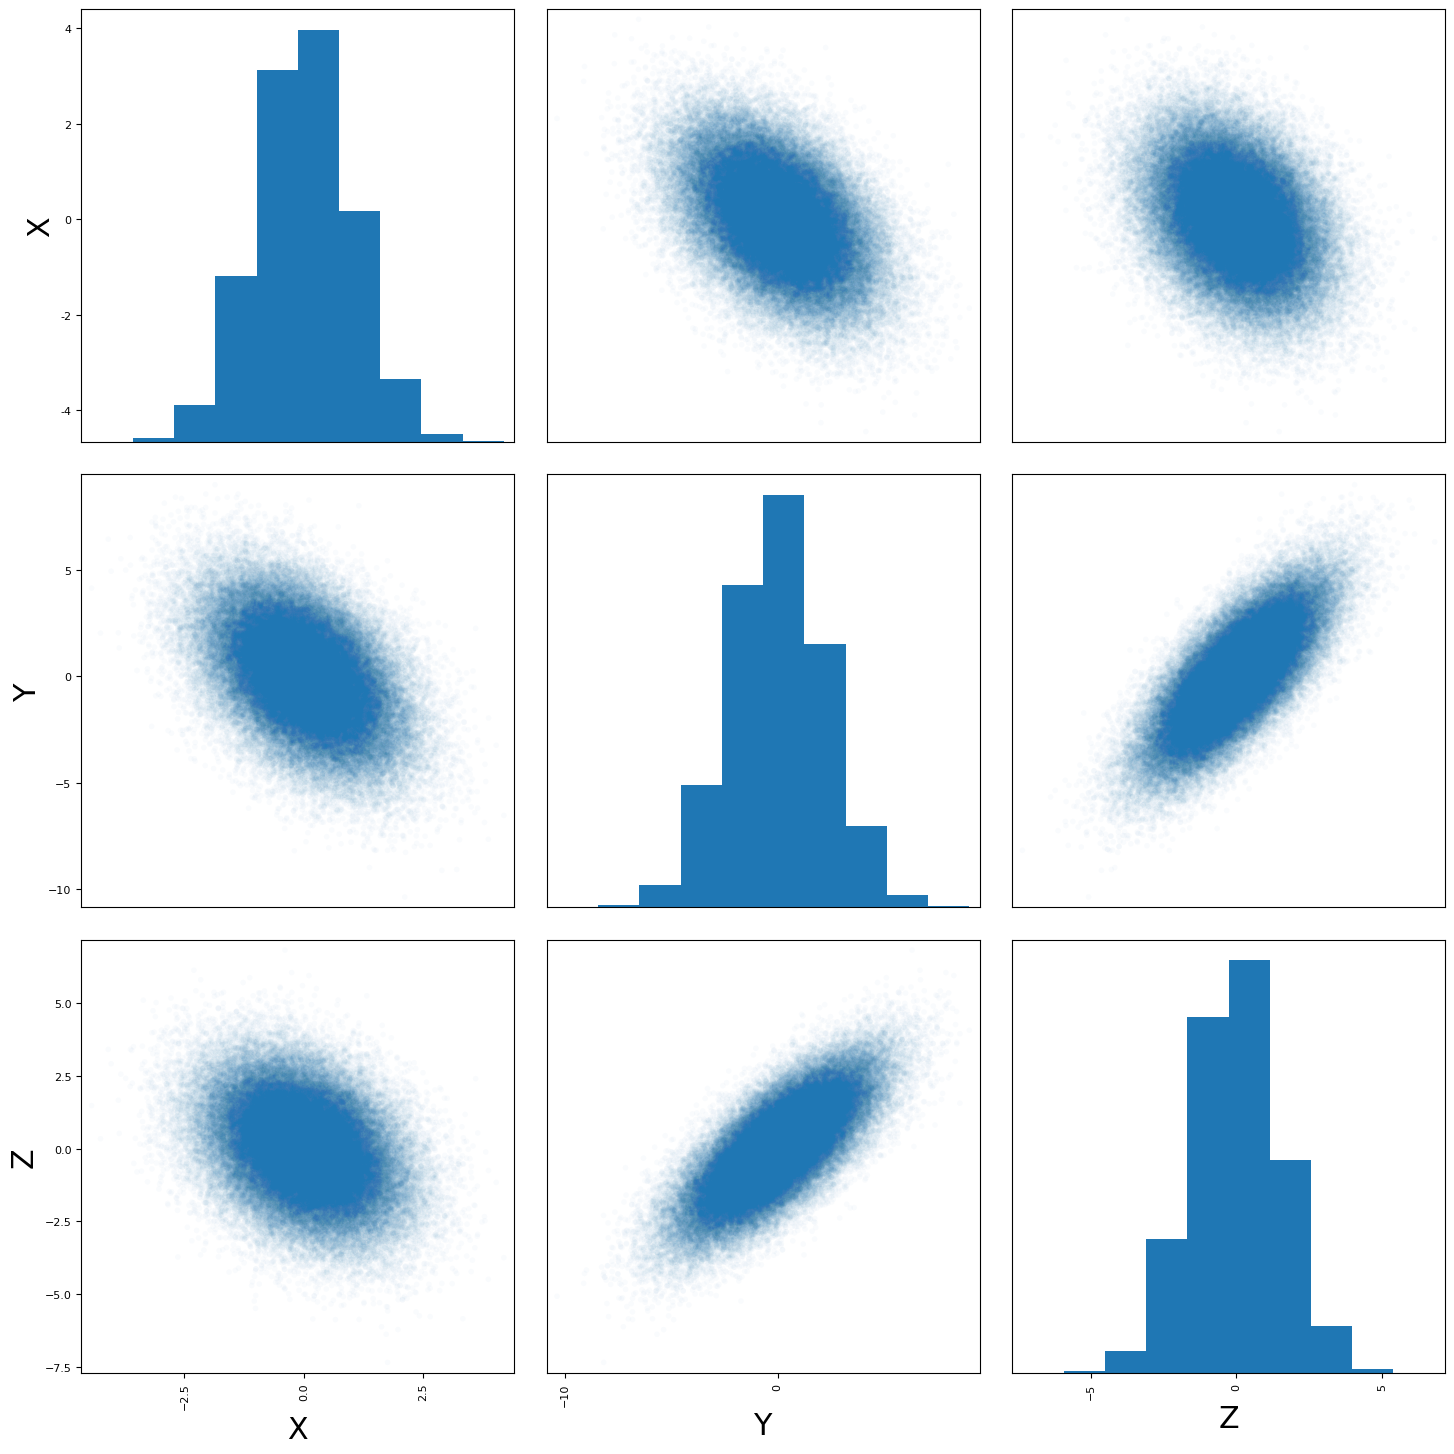

In [4]:
from datlib.plots import *
formatted_scatter_matrix(chain, alpha = .025)

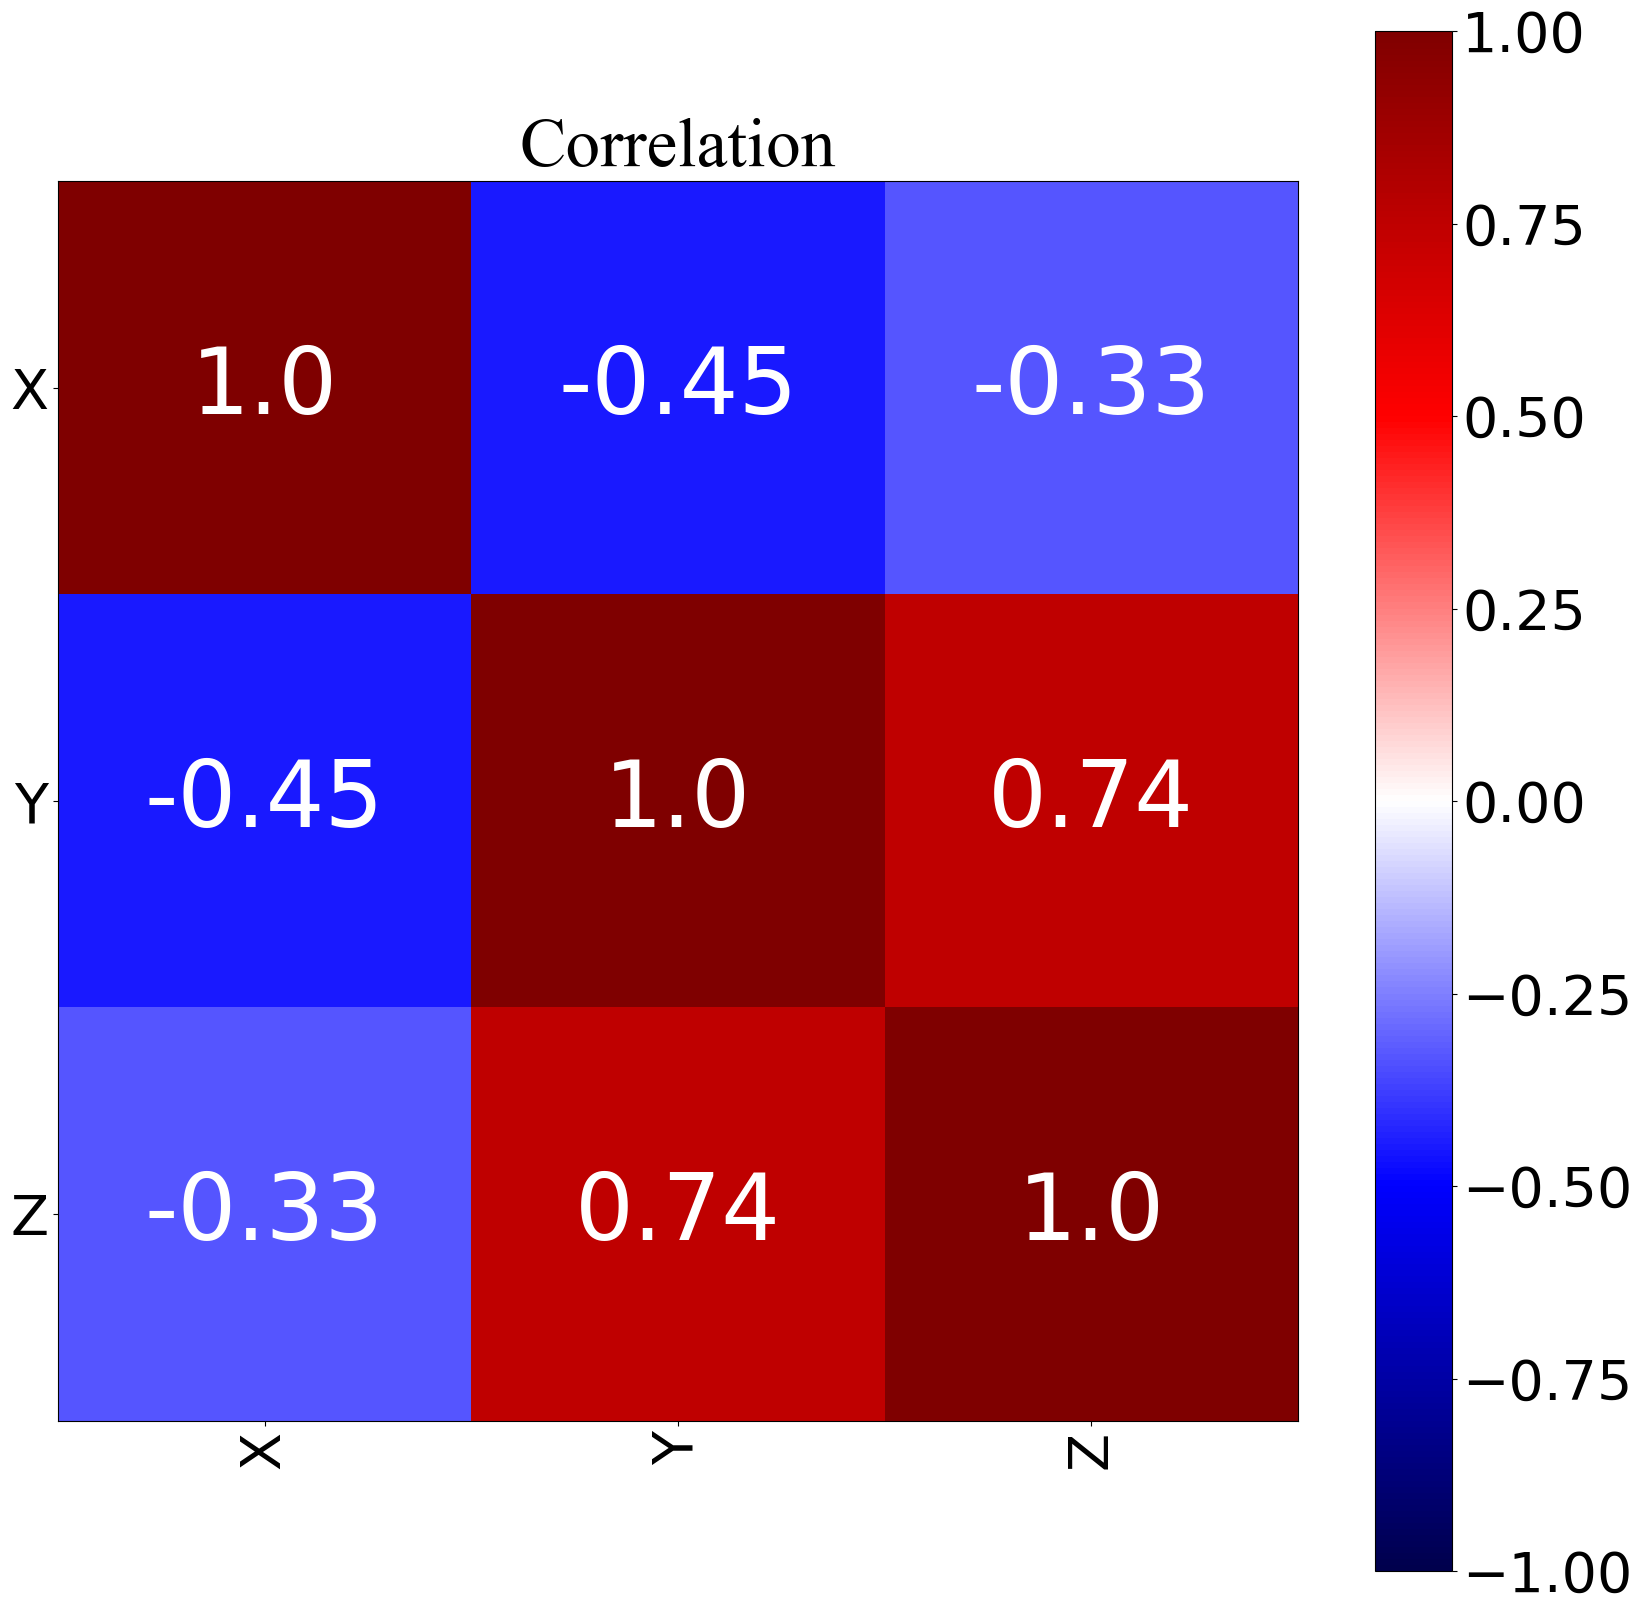

In [5]:
corr_matrix_heatmap(chain.corr(), 
                    save_fig = False, 
                    pp = None, 
                    title = "Correlation")

If we control for $Y$, however, we see that that there is no longer any correlation between $X$ and $Z$. This is called a partial correlation. In the following matrix, partial correlations of each pair are calculated using the remaing variable as a control. We can interpret the result as:

$X \!\perp\!\!\!\perp Z|Y$ 

$Corr(X,Z|Y)\approx 0.00$

First, let's substantiate this intuition using an OLS regression. We run the regression for:

$X = \beta_0 + \beta_Y + \beta_Z + \epsilon_X$

In [6]:
import statsmodels.api as sm

YZc = chain[["Y","Z"]]
YZc["Constant"] = 1
X = chain[["X"]]
# pass y_var as list for consistent structure
model = sm.OLS(X, YZc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                 1.261e+04
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:30:25   Log-Likelihood:            -1.3068e+05
No. Observations:              100000   AIC:                         2.614e+05
Df Residuals:                   99997   BIC:                         2.614e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y             -0.2020      0.002   -106.453      0.000      -0.206      -0.198
Z              0.0014      0.003      0.501      0.616      -0.004       0.007
Constant       0.0027      0.003      0.961      0.337      -0.003       0.008
==============================================================================
Omnibus:                        7.241   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.148
Skew:                          -0.013   Prob(JB):                       0.0280
Kurtosis:                       2.968   Cond. No.                         2.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Controlling for $Y$, there is no statistically significant relationship between $Z$ and $X$. To calculate the partial correlation, we can simply, we can simply calculate the negative correlation of the residuals, $\epsilon_X$, $\epsilon_Y$, and $\epsilon_Z$. First let's gather the residuals:

In [7]:
residuals = {}
def get_residuals(df):
    for y_var in df.keys():
        X_vars = list(df.keys())
        X_vars.remove(y_var)
        X = df[X_vars]
        # Initial estimate should include constant
        #   This won't be the case we regress the errors
        X["Constant"] = 1
        # pass y_var as list for consistent structure
        y = df[[y_var]]
        model = sm.OLS(y, X)
        results = model.fit()
        residuals["$\\epsilon_{" + y_var + "}$"] = results.resid
    return pd.DataFrame(residuals)
residuals = get_residuals(chain)
residuals

$\epsilon_{X}$  $\epsilon_{Y}$  $\epsilon_{Z}$
0            0.145293        1.345974       -0.744057
1           -0.360556       -2.593447        1.179922
2            0.386062        0.895296        0.932429
3           -1.945582       -0.556694        0.485340
4           -0.222024        1.473570       -0.020751
...               ...             ...             ...
99995        1.712726        1.548149       -0.986571
99996       -0.175055       -1.618666        1.404844
99997        0.886261       -1.678531        1.423695
99998       -0.140115        0.330822       -1.710762
99999        0.355513       -1.390055       -0.050751

[100000 rows x 3 columns]

Now we can calculate correlations between residuals. Notice that the signs on the correlations are in the incorrect direction.

In [8]:
residuals.corr()

$\epsilon_{X}$  $\epsilon_{Y}$  $\epsilon_{Z}$
$\epsilon_{X}$        1.000000        0.319045       -0.001584
$\epsilon_{Y}$        0.319045        1.000000       -0.705750
$\epsilon_{Z}$       -0.001584       -0.705750        1.000000

Let's build a function to correct this.

In [9]:
def calculate_partial_corr(residuals):
    pcorr = residuals.corr() * -1
    for x in residuals.keys():        
        for y in residuals.keys():
            if x == y:
                pcorr[y][x] = 1
    return pcorr
# use variable names since are correcting correlations of residuals to reflect
#  partial correlation of respective variables 
chain_pcorr = calculate_partial_corr(residuals.rename(columns = {r:r[-3] for r in residuals.keys()}))
chain_pcorr.round(3)

X      Y      Z
X  1.000 -0.319  0.002
Y -0.319  1.000  0.706
Z  0.002  0.706  1.000

We can compare our results to the pcorr() dataframe method that reference the pingouin module. We can also check the p-value of specific particular partial-correlations. Notice that the p=value of the partial correlation of $X$ and $Z$ match the p-value of $\beta_Z$ in the regression that we computed above. 

In [10]:
import pingouin
chain.pcorr().round(3)

X      Y      Z
X  1.000 -0.319  0.002
Y -0.319  1.000  0.706
Z  0.002  0.706  1.000

In [11]:
pingouin.partial_corr(data=chain, x='X', y='Z', covar='Y').round(3)

n      r         CI95%  p-val
pearson  100000  0.002  [-0.0, 0.01]  0.616

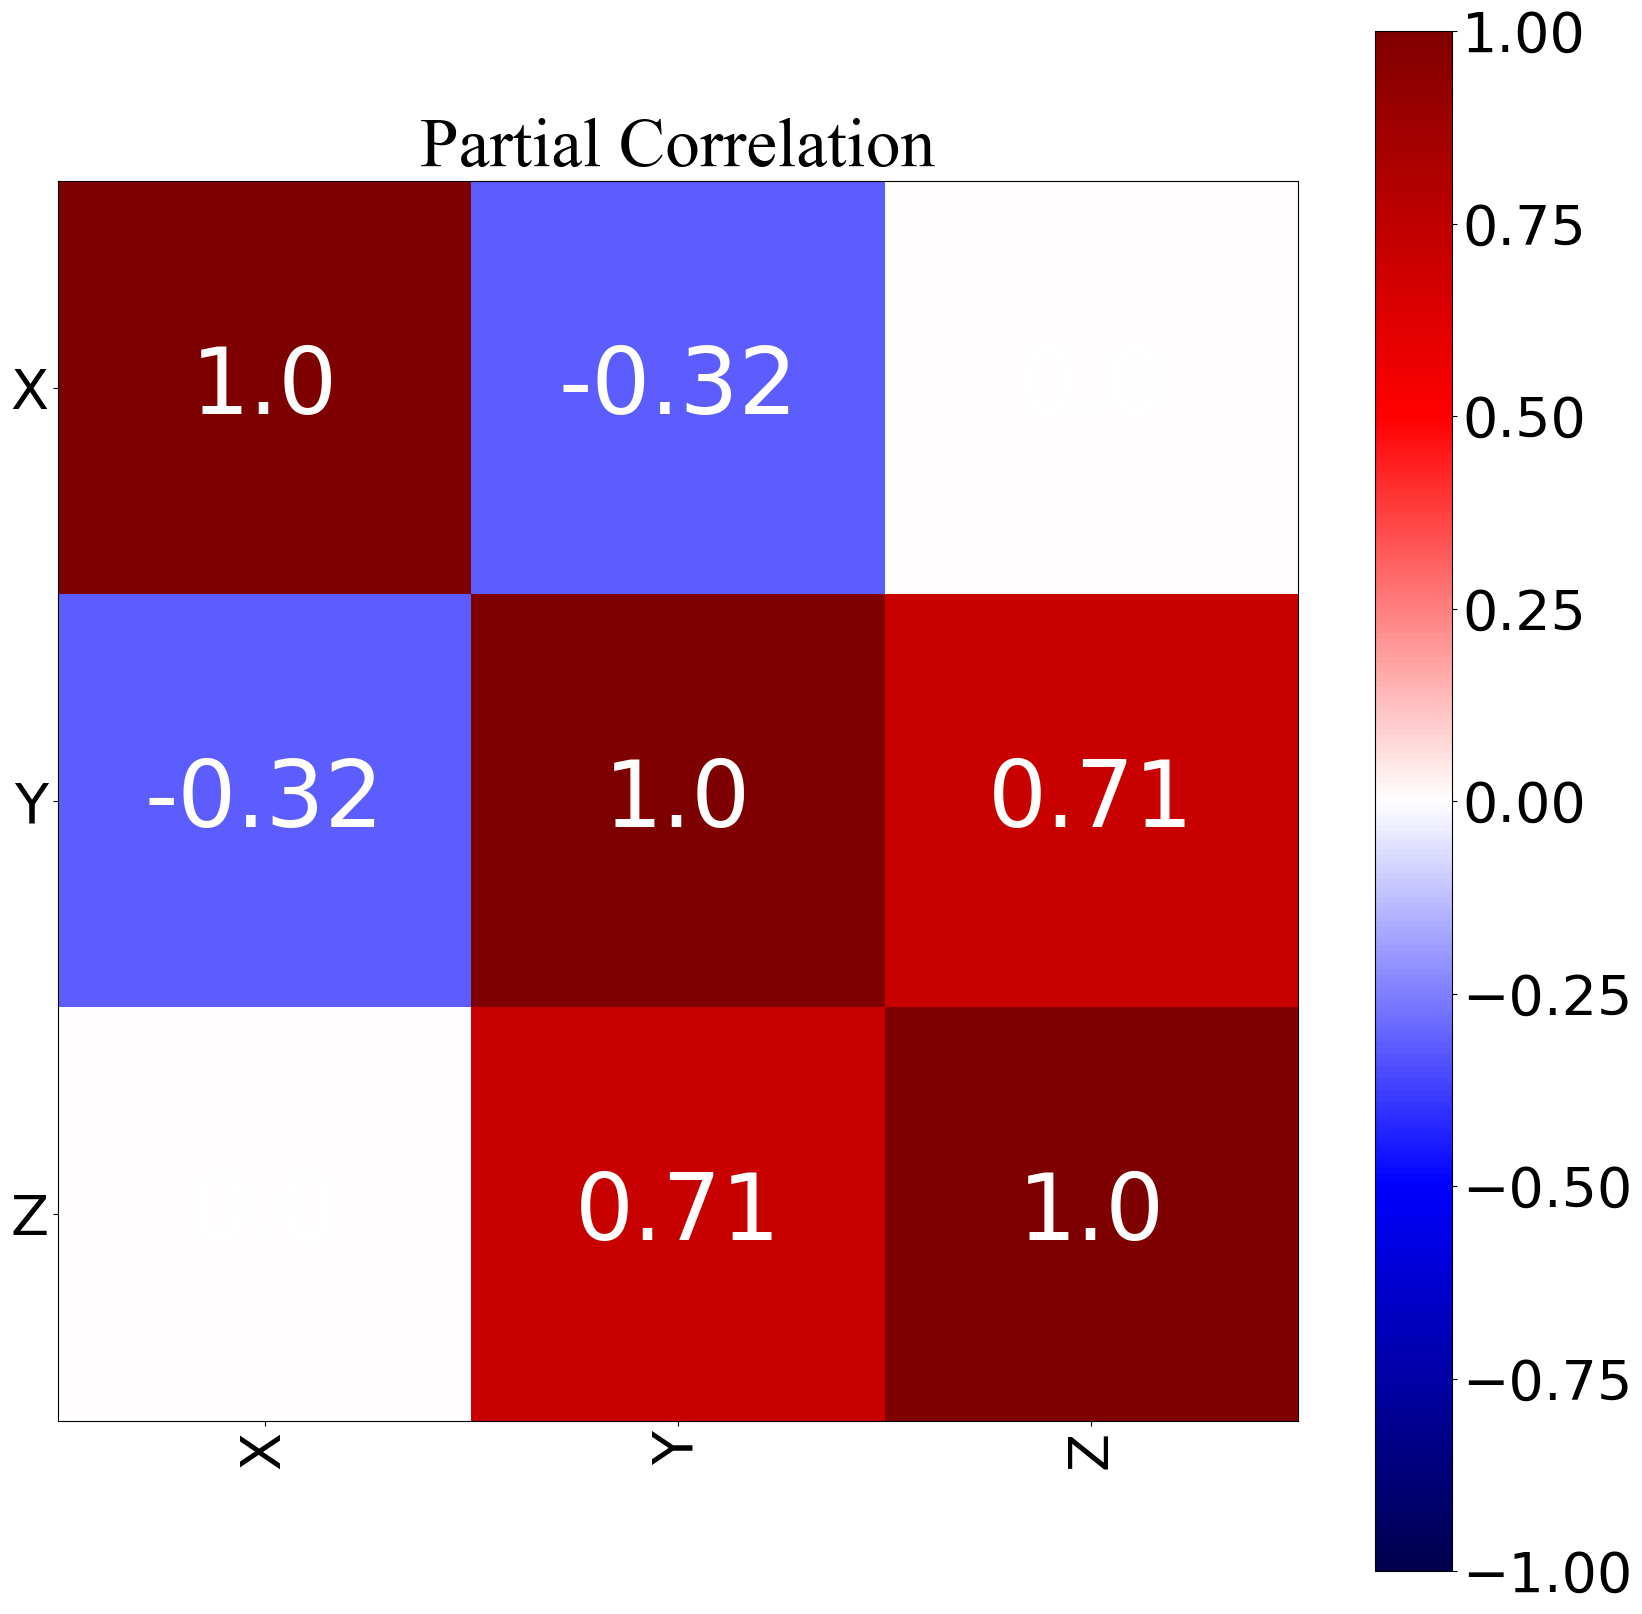

In [12]:
corr_matrix_heatmap(chain_pcorr,
                    save_fig = False,
                    pp = None, 
                    title = "Partial Correlation")

We can visualize the lack of correspondence between $X$ and $Z$ when y is included as a control by plotting $X$ and $Y$ on a cartesian plane letting color reflect the values of $Z$. The values of $Z$ are clearly correlated with the values of $Y$. However, they do not seem to change as we move from left to right. That is, for a given $X$, $Z$ and $Y$ are clearly correlated. However, for a given $Y$, the correlation between $Z$ and $X$ breaks down.

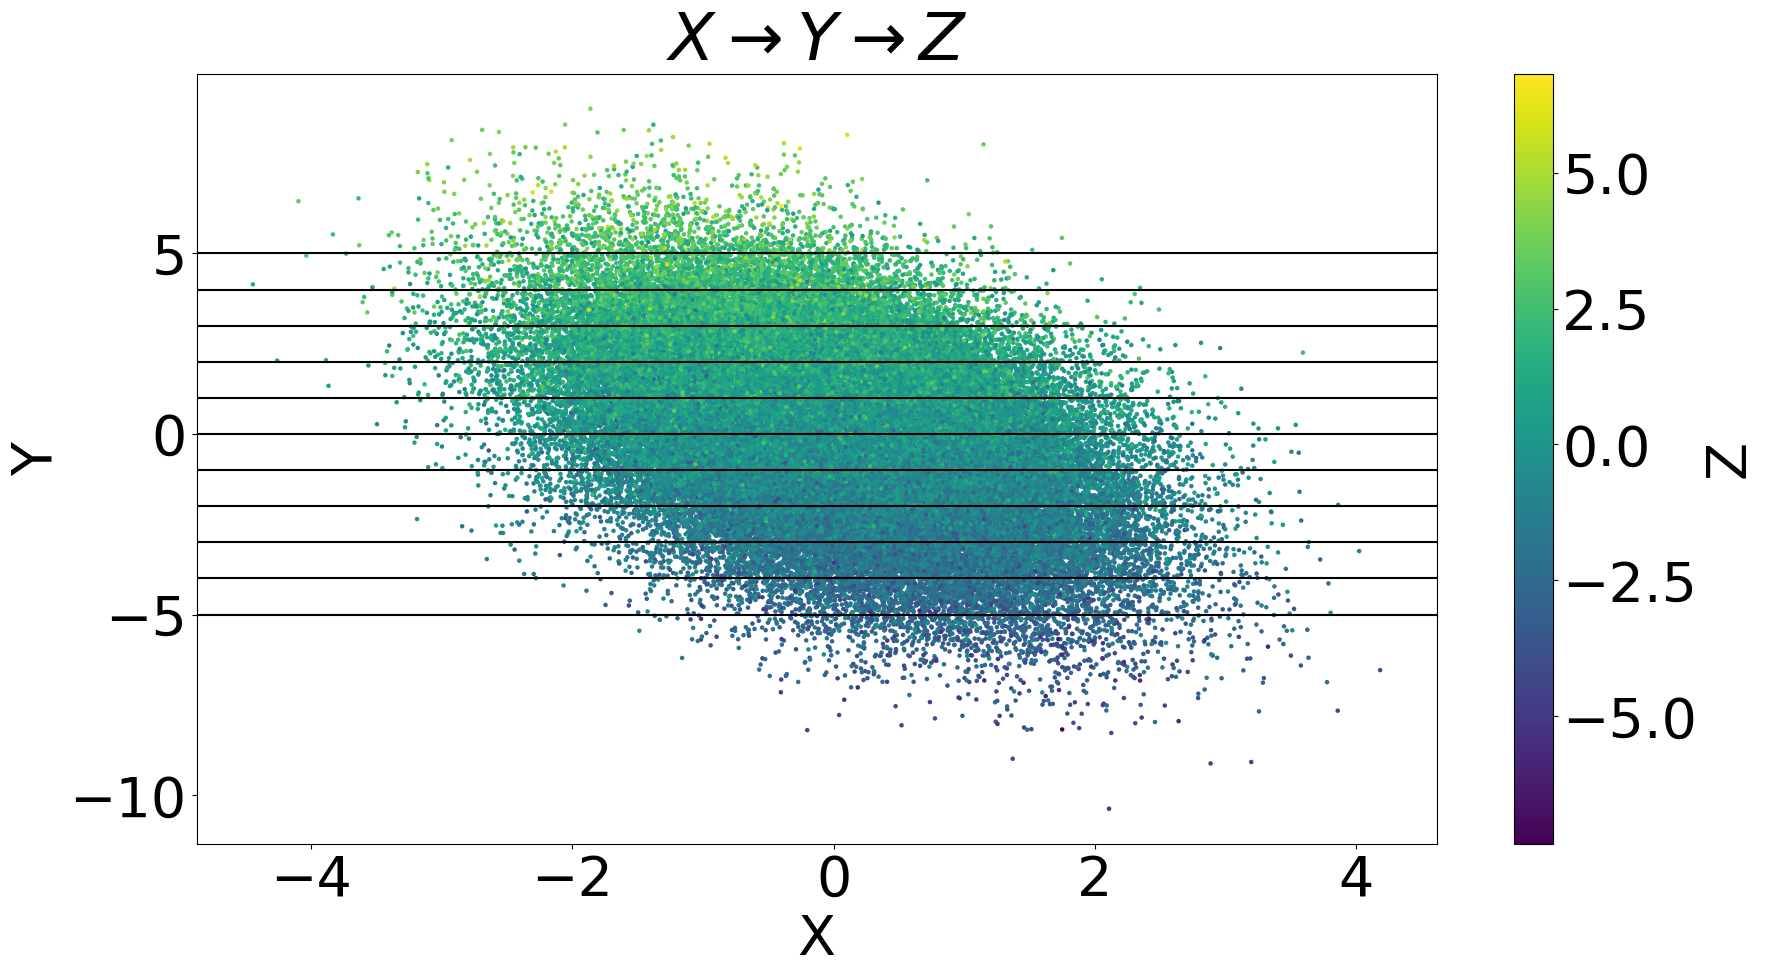

In [13]:
fig,ax = plt.subplots(figsize = (20,10))
chain.plot.scatter(x = "X", y = "Y", c = "Z", cmap = "viridis", s = 5, ax = ax)
ax.set_title("$X \\rightarrow Y \\rightarrow Z$")
for i in range(-5,6): ax.axhline(i, c = "k")

## Forks

Suppose that a variable $X$ generates variables $Y$ and $Z$, thus yielding $Y\leftarrow X \rightarrow Z$. And suppose that $Y$ and $Z$ do not directly related. Again, all three variables will be correlated. However, in the case of this fork, correlation between $Y$ and $Z$ is due to confounding from the common cause of $X$. $Y$ and $Z$ are D-separated by $X$.

Text(0.5, 1.0, 'Fork')

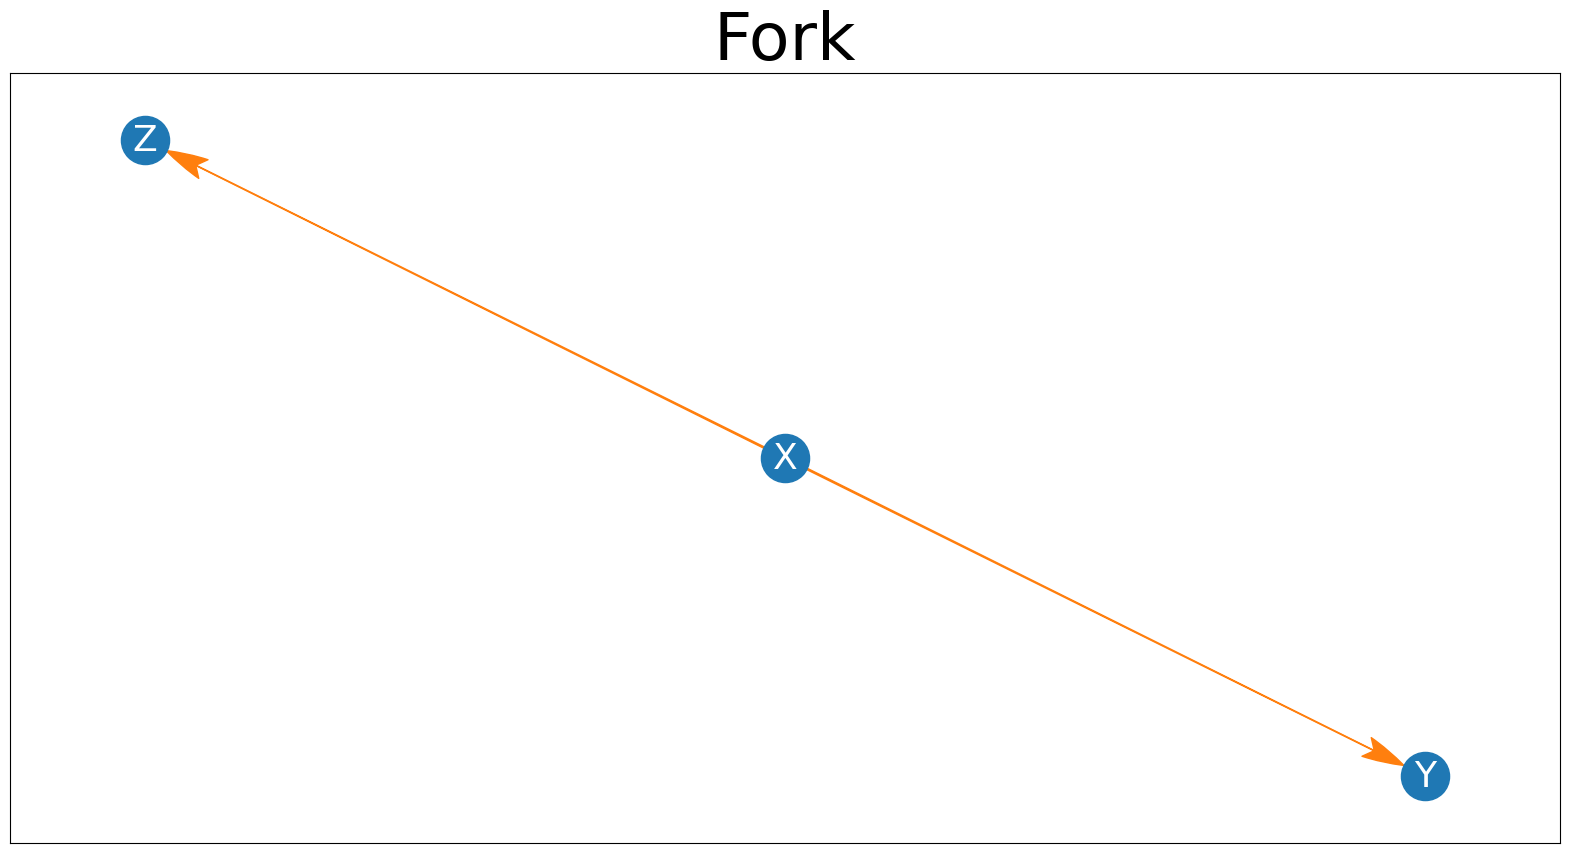

In [14]:
G = nx.DiGraph()
G.add_edges_from([("X","Y"),("X","Z")])
pos = nx.spring_layout(G)#, k = 5/(len(sig_corr.keys())**.5))

fig,ax  = plt.subplots(figsize = (20,10))
# plt.title(title, fontsize = 30)
nx.draw_networkx(G, pos,node_size = 1200,
     with_labels=True,  arrows=True,
     font_color = "white",
     font_size = 26, alpha = 1,
     width = 1, edge_color = "C1",
     arrowstyle=ArrowStyle(
         "Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                ax = ax)
ax.set_title("Fork")

Again, we can generate variables that follow the pattern:

In [15]:
fork = {col:[] for col in cols}
for i in range(length):
    fork["X"].append(np.random.normal(0, 1))
    fork["Y"].append(fork["X"][-1] + np.random.normal(0, 1))
    fork["Z"].append(fork["X"][-1] * 2 + np.random.normal(0, 1))
fork = pd.DataFrame(fork)
fork

X         Y         Z
0      1.966671  2.406448  5.467730
1     -0.599204 -1.657361 -0.934105
2     -0.788936 -0.634502 -1.976353
3      0.672162 -1.395681  1.050470
4      1.534565  3.266138  3.585381
...         ...       ...       ...
99995  1.149469  0.481649  1.456228
99996  0.234048 -0.186116  1.298209
99997  1.882900  0.834909  4.097320
99998 -1.911929 -2.487172 -4.345162
99999 -0.668061 -1.298360 -1.287702

[100000 rows x 3 columns]

In [16]:
fork.corr()

X         Y         Z
X  1.000000  0.707780  0.894764
Y  0.707780  1.000000  0.634666
Z  0.894764  0.634666  1.000000

While all three variables are correlated, we will see that a regression of $Y$ on $X$ and $Z$ will yields a statistically insignificant estimate for $\beta_Z$.

In [17]:
XZc = fork[["X","Z"]]
XZc["Constant"] = 1
Y = fork[["Y"]]
# pass y_var as list for consistent structure
model = sm.OLS(Y, XZc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                 5.019e+04
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:30:28   Log-Likelihood:            -1.4191e+05
No. Observations:              100000   AIC:                         2.838e+05
Df Residuals:                   99997   BIC:                         2.839e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.9915      0.007    140.247      0.000       0.978       1.005
Z              0.0043      0.003      1.374      0.169      -0.002       0.011
Constant       0.0007      0.003      0.214      0.831      -0.006       0.007
==============================================================================
Omnibus:                        2.465   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                2.467
Skew:                          -0.007   Prob(JB):                        0.291
Kurtosis:                       3.020   Cond. No.                         5.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This will be reflected in the partial correlation of $Y$ and $Z$:

In [18]:
pingouin.partial_corr(data=fork, x='Y', y='Z', covar='X').round(3)

n      r         CI95%  p-val
pearson  100000  0.004  [-0.0, 0.01]  0.169

The intuition of this partial correlation can be visualized by plotting $X$ and $Y$ on a cartesian plane while using $Z$ to color each observation. $X$ and $Y$ are obviously correlated. The color, representing values of $Z$, only changes as we move from top to bottom, not from left to right. An easy way to detect this is to look at values at the far right and at the far left. Small values of $X$ only reflect darker colors while high values of $X$ only reflect bright colors.

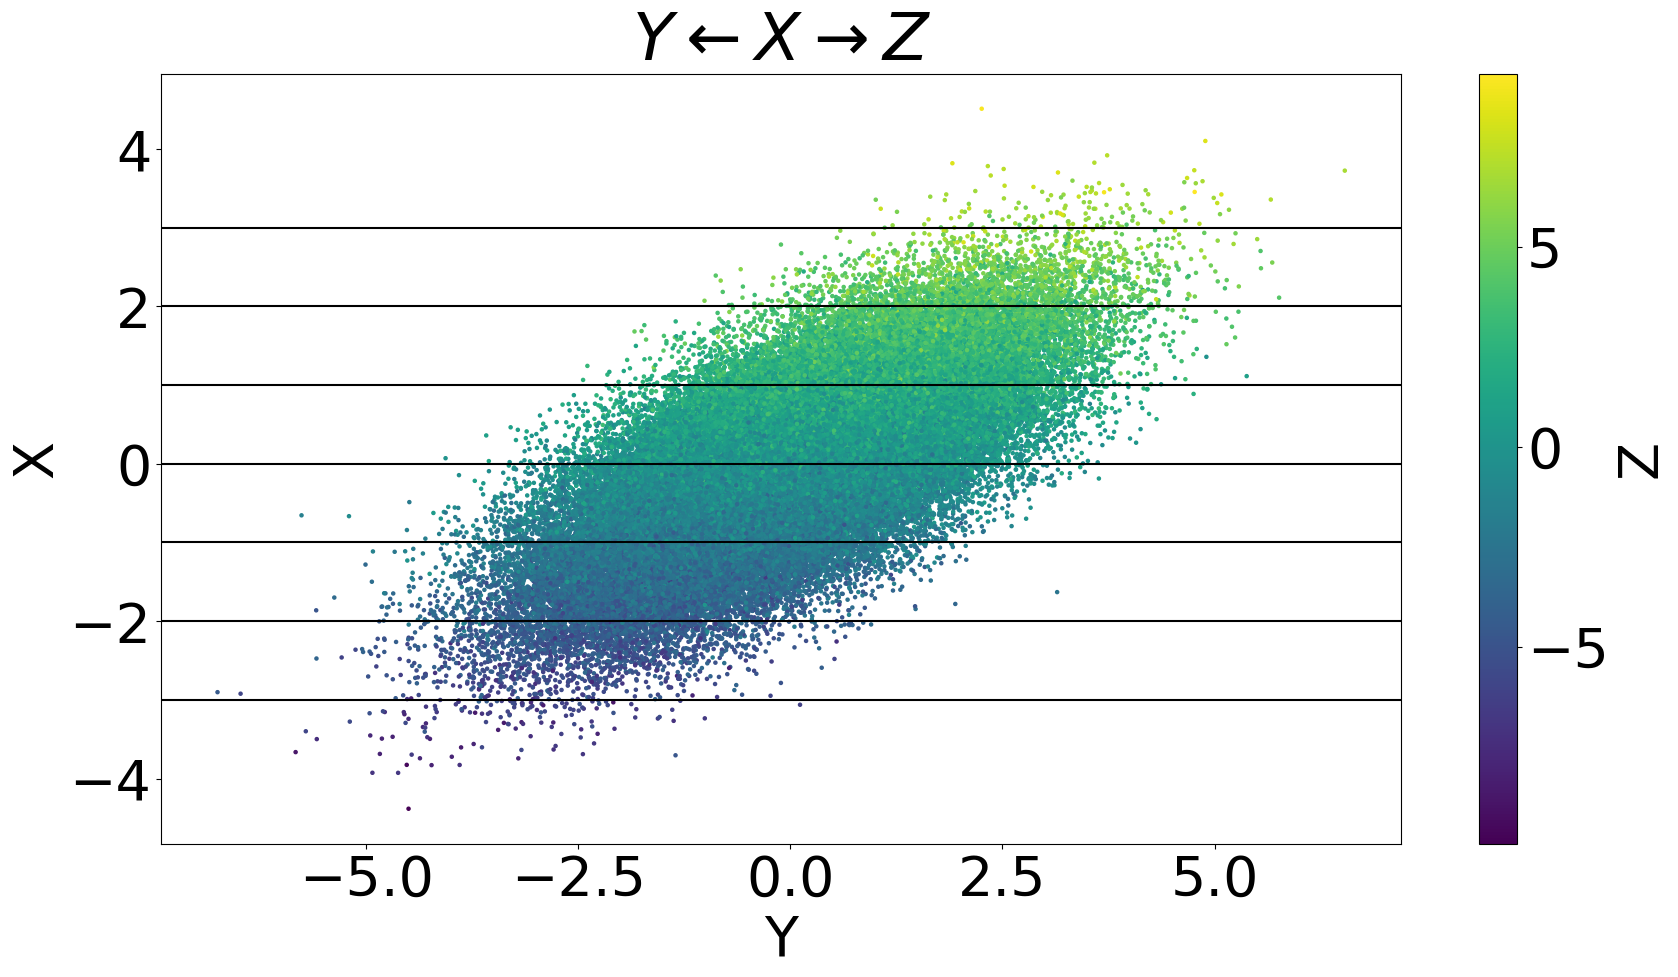

In [19]:
fig,ax = plt.subplots(figsize = (20,10))
fork.plot.scatter(x = "Y", y = "X", c = "Z",s = 5, cmap = "viridis", ax = ax)
ax.set_title("$Y \\leftarrow X \\rightarrow Z$")
for i in range(-3,4): ax.axhline(i, c = "k")

## Colliders

Finally, a variable, $X$, might be the result of two variables, $Y$ and $Z$. When this is the case, $Y$ and $Z$ are independent, but when controlling for $X$, we find that they are correlated.

Text(0.5, 1.0, 'Collider')

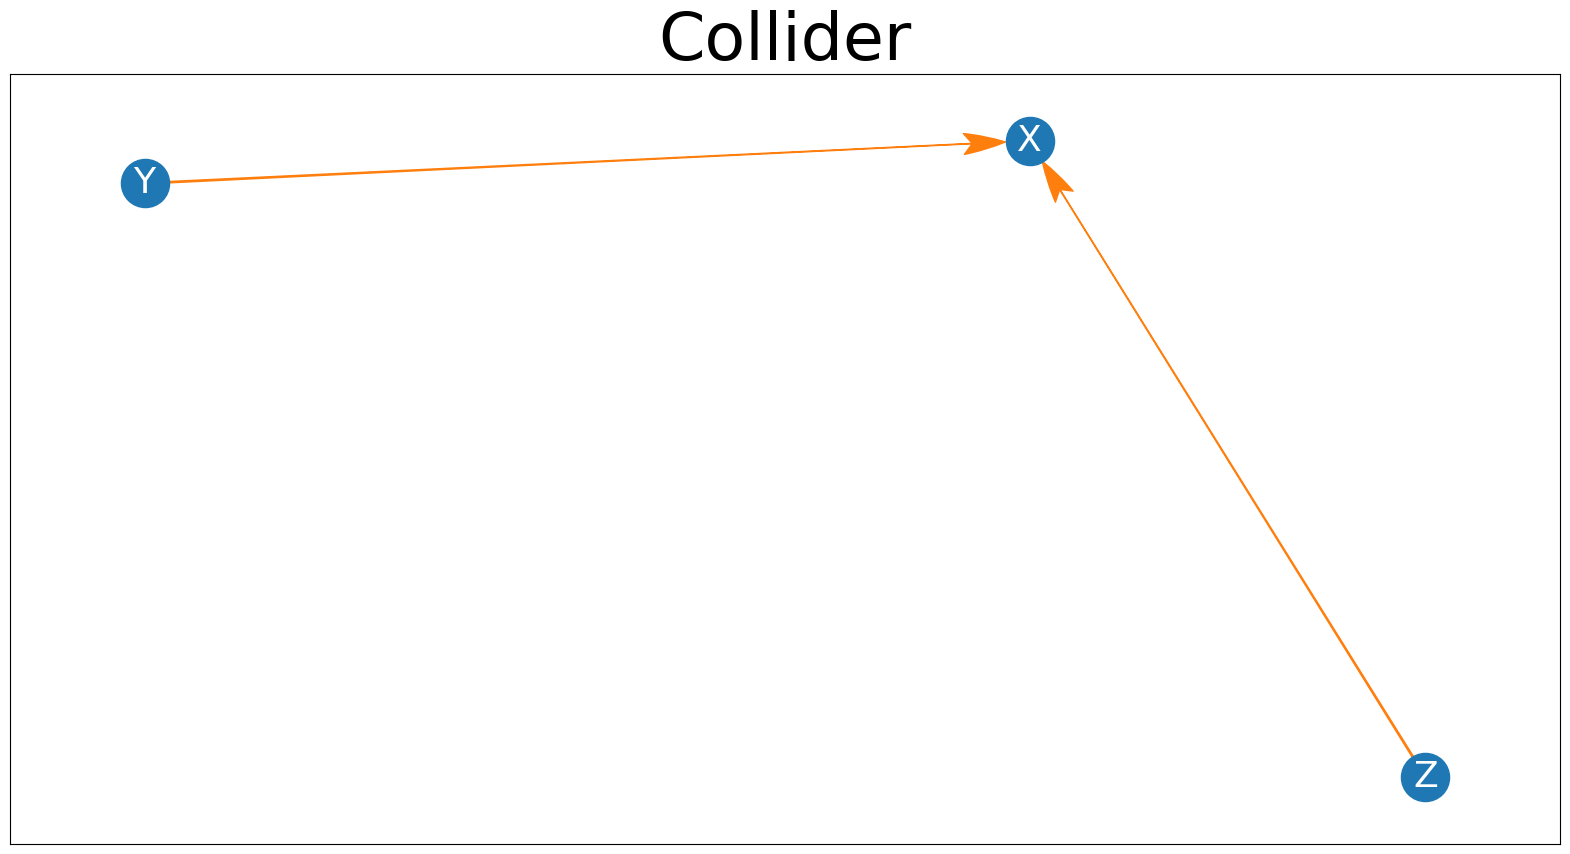

In [20]:
G = nx.DiGraph()
G.add_edges_from([("Y","X"),("Z","X")])
pos = nx.spring_layout(G)#, k = 5/(len(sig_corr.keys())**.5))

fig,ax  = plt.subplots(figsize = (20,10))
# plt.title(title, fontsize = 30)
nx.draw_networkx(G, pos,node_size = 1200,
     with_labels=True,  arrows=True,
     font_color = "white",
     font_size = 26, alpha = 1,
     width = 1, edge_color = "C1",
     arrowstyle=ArrowStyle(
         "Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                ax = ax)
ax.set_title("Collider")

In [21]:
collider = {col:[] for col in cols}
for i in range(length):
    collider["Y"].append(np.random.normal(0, 1))
    collider["Z"].append(np.random.normal(0, 1))
    collider["X"].append(collider["Y"][-1] * -.5 + collider["Z"][-1] * .5 + np.random.normal(0, 1))
collider = pd.DataFrame(collider)
collider

X         Y         Z
0     -0.627819  0.941645  0.406644
1      0.575344 -1.047457  2.093048
2     -1.153122 -0.128328 -0.882324
3      1.135863  0.901652  0.229736
4     -0.974825  1.519942  0.575611
...         ...       ...       ...
99995 -0.680425  0.579560 -0.191131
99996  1.256644  0.494379  1.967836
99997 -1.354942 -0.138550  1.017390
99998 -0.796955  1.193991 -0.727086
99999  0.823050  1.894337  1.656700

[100000 rows x 3 columns]

In [22]:
collider.corr()

X         Y         Z
X  1.000000 -0.405365  0.408232
Y -0.405365  1.000000  0.000937
Z  0.408232  0.000937  1.000000

In [23]:
YZc = collider[["Y","Z"]]
YZc["Constant"] = 1
X = collider[["X"]]
# pass y_var as list for consistent structure
model = sm.OLS(X, YZc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                 2.477e+04
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:30:30   Log-Likelihood:            -1.4213e+05
No. Observations:              100000   AIC:                         2.843e+05
Df Residuals:                   99997   BIC:                         2.843e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y             -0.4974      0.003   -156.902      0.000      -0.504      -0.491
Z              0.4984      0.003    158.010      0.000       0.492       0.505
Constant       0.0017      0.003      0.541      0.588      -0.004       0.008
==============================================================================
Omnibus:                        1.216   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.544   Jarque-Bera (JB):                1.227
Skew:                          -0.007   Prob(JB):                        0.542
Kurtosis:                       2.991   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While $Y$ and $Z$ are not correlated, controlling for $X$, we see that their exists a statistically significant partial correlation. Thus, we can be confident that $Y$ and $Z$ are, in fact, influencing the value of $X$.

In [24]:
pingouin.partial_corr(data=collider, x='Y', y='Z', covar='X').round(3)

n      r         CI95%  p-val
pearson  100000  0.199  [0.19, 0.21]    0.0

We can visualize this insight by comparing the values of $Y$ and $Z$. The positions of each observation exhibit no correlation. However, when we represent the third dimension, $X$, using the colormap, we can see that the values of X are correlated with both $Y$ and $Z$, with darker colors on the bottom-right and lighter colors on the top-left. 

Text(0.5, 1.0, '$Y \\rightarrow X \\leftarrow Z$')

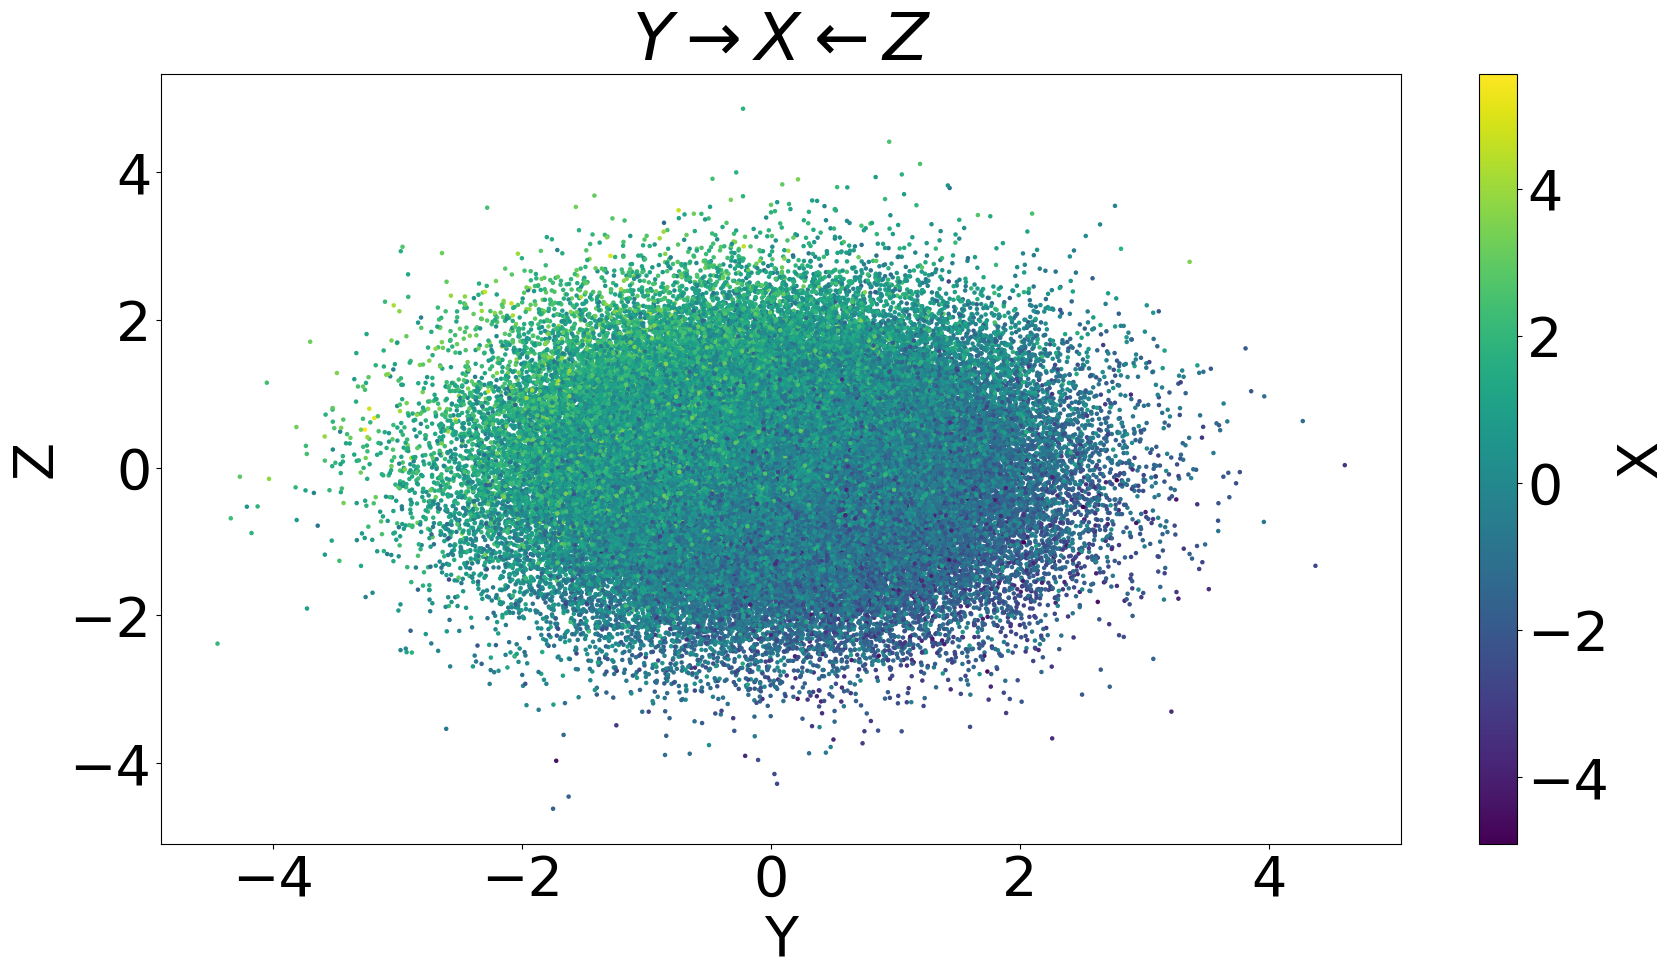

In [25]:
fig,ax = plt.subplots(figsize = (20,10))
collider.plot.scatter(x = "Y", y = "Z", c = "X",s = 5, cmap = "viridis", ax = ax)
ax.set_title("$Y \\rightarrow X \\leftarrow Z$")

## Problems with Confounding

Confounding exists where some unknown variable is impacting, either directly or indirectly, both the explanatory and the explained variable. If possible, we want to block the effect of the confounding variable. We say that two variables are desparated when all paths between them are blocked. For example, variables $Y$ and $Z$ in the collider example are d-separated because there is no path from $Y$ to $X$ or vice versa. In the example of the chain $X \rightarrow Y \rightarrow Z$, $X$ and $Z$ are not d-separated as there exists a path from $X$ to $Z$. We can block this path by controlling for $Y$. This is reflected by a lack of statistical significance in the partial correlation of $X$ and $Z$ controlling for $Y$, $\rho_{xz.y}$.

The problem of d-separation helps us to understand sources of bias that plague estimates and how to control for them.


### Backdoor

Text(0.5, 1.0, 'Backdoor Criterion')

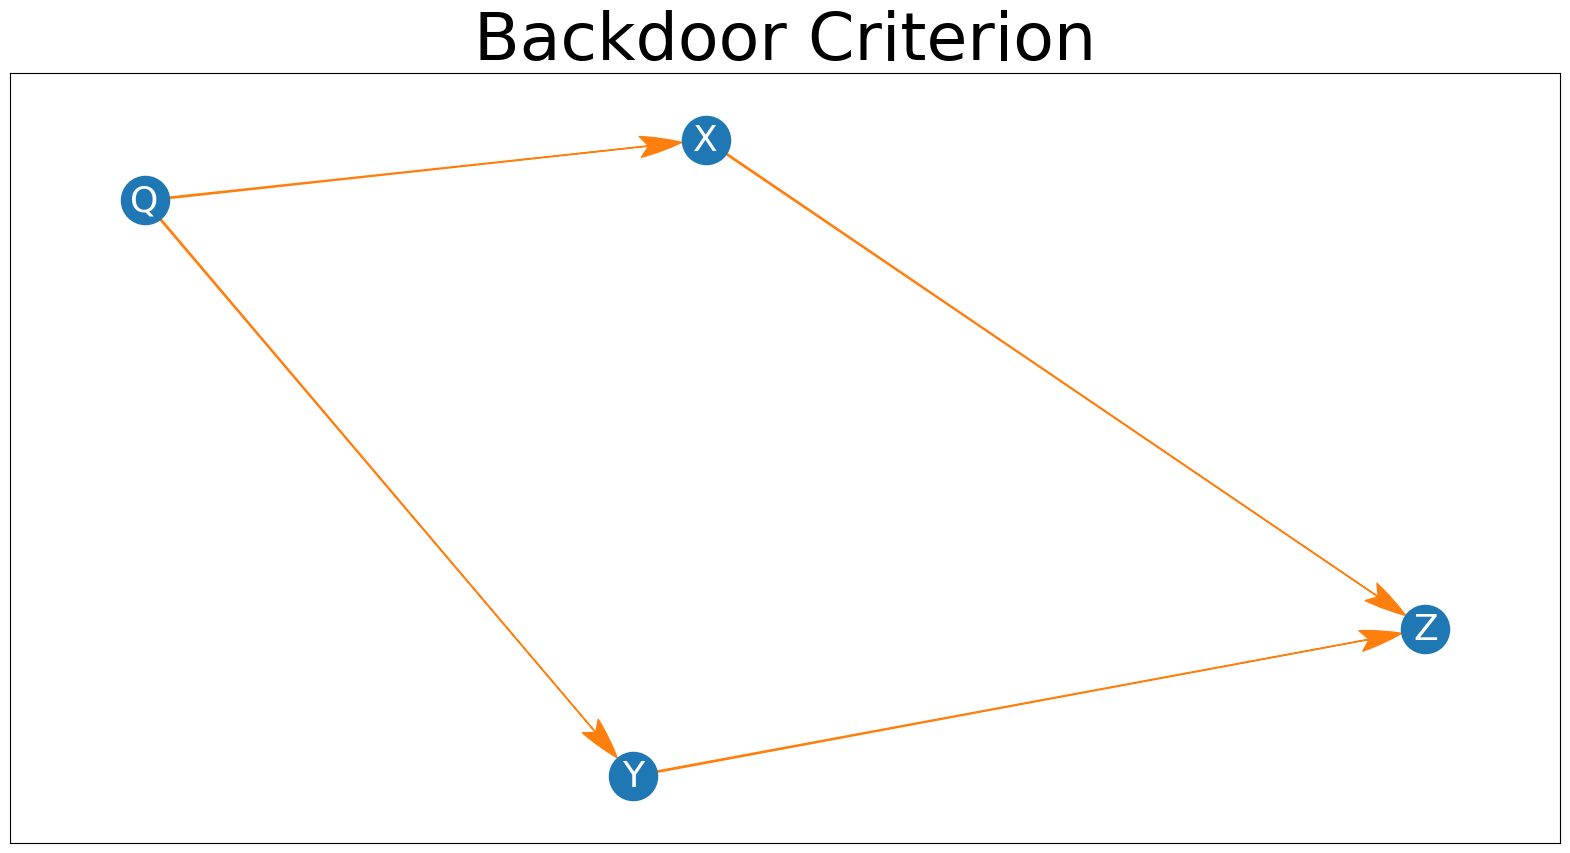

In [26]:
G = nx.DiGraph()
G.add_edges_from([("Q","X"),("Q","Y"), ("X","Z"),("Y","Z")])
pos = nx.spring_layout(G)#, k = 5/(len(sig_corr.keys())**.5))

fig,ax  = plt.subplots(figsize = (20,10))
# plt.title(title, fontsize = 30)
nx.draw_networkx(G, pos,node_size = 1200,
     with_labels=True,  arrows=True,
     font_color = "white",
     font_size = 26, alpha = 1,
     width = 1, edge_color = "C1",
     arrowstyle=ArrowStyle(
         "Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                ax = ax)
ax.set_title("Backdoor Criterion")

In [27]:
cols = ["Q", "X", "Y", "Z"]
mu = 0
sigma = 1


backdoor = {col:[] for col in cols}
for i in range(length):
    backdoor["Q"].append(np.random.normal(mu, sigma))
    backdoor["X"].append(3 * backdoor["Q"][-1]  + np.random.normal(mu, sigma ))
    backdoor["Y"].append(backdoor["Q"][-1] * -1 +  np.random.normal(mu, sigma))
    backdoor["Z"].append(1.5 * backdoor["X"][-1] -  backdoor["Y"][-1] * 2 +  np.random.normal(mu,  sigma))

backdoor = pd.DataFrame(backdoor)
backdoor

Q         X         Y         Z
0      0.305158  1.429657  0.970187  0.967745
1      0.582669  1.778090 -0.339435  2.222836
2      0.219543  0.561742  1.274339 -2.335607
3      0.329428  0.142677 -0.456787  0.070641
4      0.399310  1.707251  0.151506  2.910043
...         ...       ...       ...       ...
99995  0.072172  0.189029 -0.830833  0.105607
99996 -0.868825 -2.676967 -0.369926 -6.785617
99997 -0.070107 -1.501985  0.625064 -3.440509
99998  0.803460  2.644348 -0.234611  4.856092
99999  0.730486  1.293870 -0.951490  2.694226

[100000 rows x 4 columns]

In [28]:
import statsmodels.api as sm

QXYc = backdoor[["Q", "X", "Y"]]
QXYc["Constant"] = 1
Z = backdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, QXYc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.611e+06
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:30:33   Log-Likelihood:            -1.4189e+05
No. Observations:              100000   AIC:                         2.838e+05
Df Residuals:                   99996   BIC:                         2.838e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q             -0.0017      0.010     -0.166      0.868      -0.022       0.019
X              1.5012      0.003    474.820      0.000       1.495       1.507
Y             -1.9973      0.003   -631.817      0.000      -2.003      -1.991
Constant       0.0005      0.003      0.148      0.882      -0.006       0.007
==============================================================================
Omnibus:                        0.602   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.740   Jarque-Bera (JB):                0.613
Skew:                          -0.004   Prob(JB):                        0.736
Kurtosis:                       2.990   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
XYc = backdoor[["X", "Y"]]
model = sm.OLS(Z, XYc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                          2.416e+06
Date:                Thu, 04 Apr 2024   Prob (F-statistic):                        0.00
Time:                        13:30:33   Log-Likelihood:                     -1.4189e+05
No. Observations:              100000   AIC:                                  2.838e+05
Df Residuals:                   99998   BIC:                                  2.838e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.5008      0.001   1114.385      0.000       1.498       1.503
Y             -1.9971      0.003   -662.887      0.000      -2.003      -1.991
==============================================================================
Omnibus:                        0.600   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.611
Skew:                          -0.003   Prob(JB):                        0.737
Kurtosis:                       2.990   Cond. No.                         3.31
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Frontdoor Criterion

In [30]:
import random
import numpy as np
import pandas as pd

cols = ["Q", "X", "Y", "Z"]
mu = 0
sigma = 1


frontdoor = {col:[] for col in cols}
for i in range(length):
    frontdoor["Q"].append(np.random.normal(mu, sigma))
    frontdoor["X"].append(10 * frontdoor["Q"][-1]  + np.random.normal(mu, sigma ))
    frontdoor["Y"].append(frontdoor["X"][-1] * 2 +  np.random.normal(mu, sigma))
    frontdoor["Z"].append(frontdoor["Q"][-1] * -1 +  frontdoor["Y"][-1] +  np.random.normal(mu,  sigma))

frontdoor = pd.DataFrame(frontdoor)
frontdoor

Q          X          Y          Z
0     -0.466061  -4.219308  -8.656482  -8.268982
1      0.979507  10.446224  20.235783  18.545873
2     -0.699926  -8.302791 -15.655313 -14.072000
3     -0.513522  -3.997791  -9.801248  -8.732682
4      1.473903  14.272218  27.782549  26.982022
...         ...        ...        ...        ...
99995  1.323495  12.519295  24.638835  22.987760
99996  0.135378   0.524911   1.516654   1.670975
99997 -1.071169 -11.397665 -22.548208 -20.563708
99998 -0.173557  -1.923160  -4.375930  -3.782719
99999  0.294713   1.114618   1.830859   0.317651

[100000 rows x 4 columns]

Text(0.5, 1.0, 'Frontdoor Criterion')

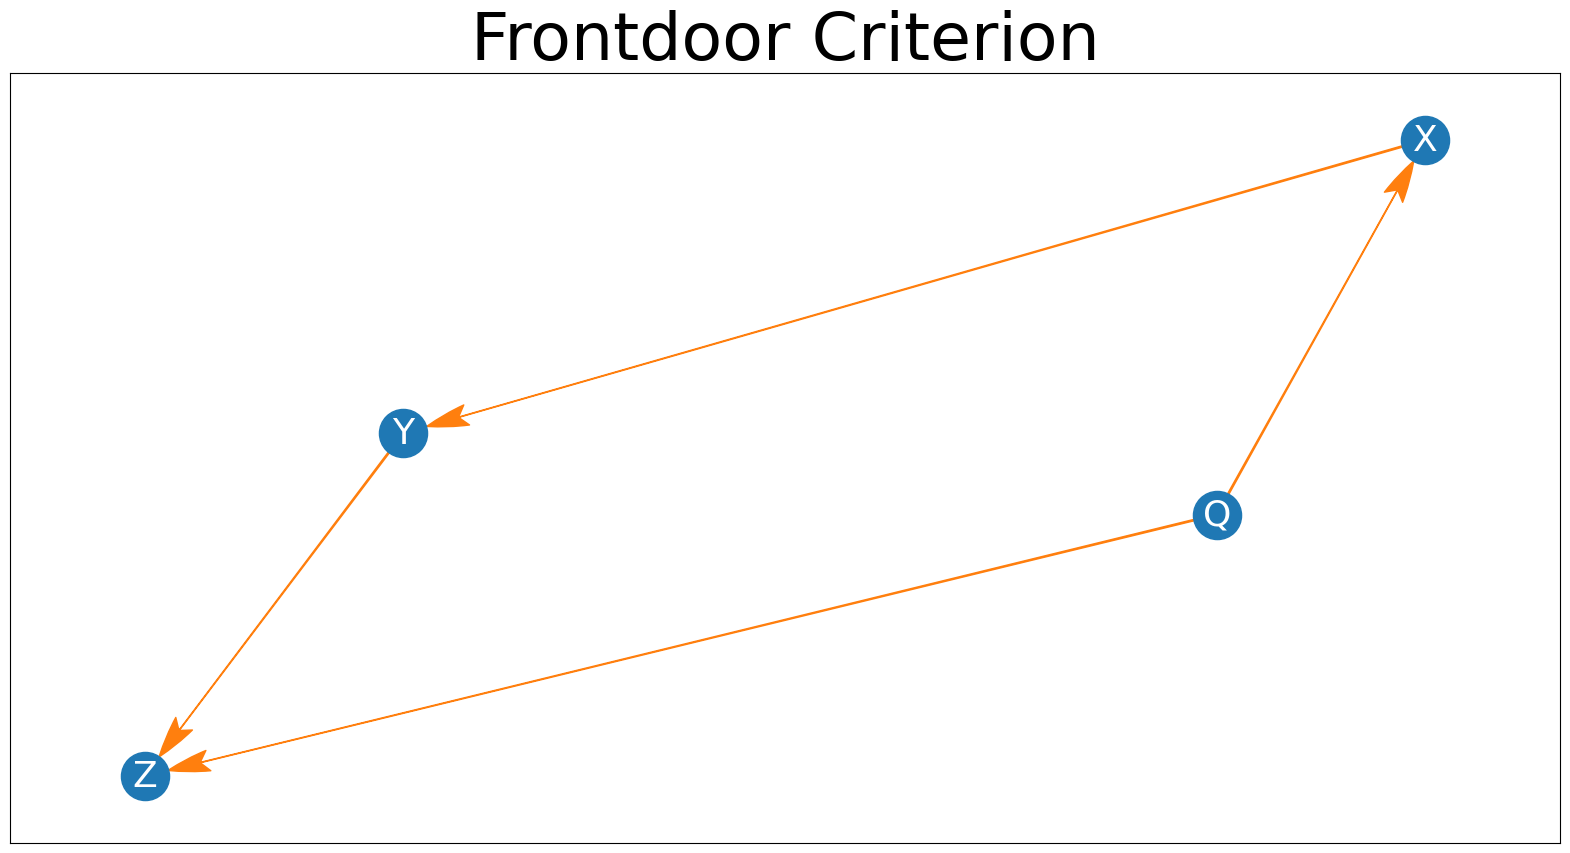

In [31]:
G = nx.DiGraph()
G.add_edges_from([("Q","X"),("Q","Z"), ("X","Y"),("Y","Z")])
pos = nx.spring_layout(G)#, k = 5/(len(sig_corr.keys())**.5))

fig,ax  = plt.subplots(figsize = (20,10))
# plt.title(title, fontsize = 30)
nx.draw_networkx(G, pos,node_size = 1200,
     with_labels=True,  arrows=True,
     font_color = "white",
     font_size = 26, alpha = 1,
     width = 1, edge_color = "C1",
     arrowstyle=ArrowStyle(
         "Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                ax = ax)
ax.set_title("Frontdoor Criterion")

The explanatory power of $Q$ is detected in the estimate of $\beta_X$ only if $Y$ is included in the estimate. This biases the estimate of $\beta_X$, but we cannot know the value of this bias without additional information.

In [32]:
import statsmodels.api as sm

Xc = frontdoor[["X"]]
Xc["Constant"] = 1
Z = frontdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, Xc)
results = model.fit()
results.summary()

C:\Users\JLCat\AppData\Local\Temp\ipykernel_23956\1196884393.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.831e+07
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:30:33   Log-Likelihood:            -1.7674e+05
No. Observations:              100000   AIC:                         3.535e+05
Df Residuals:                   99998   BIC:                         3.535e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.9010      0.000   4278.861      0.000       1.900       1.902
Constant       0.0043      0.004      0.949      0.343      -0.005       0.013
==============================================================================
Omnibus:                        1.169   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.557   Jarque-Bera (JB):                1.173
Skew:                          -0.008   Prob(JB):                        0.556
Kurtosis:                       2.997   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Without inclusion of $Q$, the effect of $X$ on $Z$ is biased, in this case, downward. We can measure the extent of this bias if we include $Y$, which is not directly effected by $Q$. The bias of our estimate of $X$ in the bivariate regression is approximately equivalent to the estimate of $\beta_X$ in the regression $Z = f(X,Y)$. 

In [33]:
import statsmodels.api as sm

XYc = frontdoor[["X", "Y"]]
XYc["Constant"] = 1
Z = frontdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, XYc)
results = model.fit()
results.summary()

C:\Users\JLCat\AppData\Local\Temp\ipykernel_23956\3038010533.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XYc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.823e+07
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:30:33   Log-Likelihood:            -1.4242e+05
No. Observations:              100000   AIC:                         2.849e+05
Df Residuals:                   99997   BIC:                         2.849e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.0945      0.006    -14.848      0.000      -0.107      -0.082
Y              0.9977      0.003    314.034      0.000       0.991       1.004
Constant       0.0027      0.003      0.863      0.388      -0.003       0.009
==============================================================================
Omnibus:                        5.560   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.568
Skew:                          -0.018   Prob(JB):                       0.0618
Kurtosis:                       2.994   Cond. No.                         50.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we don't include $Y$, the effect of $X$ transmitted through $Y$ is detected.

In [34]:
import statsmodels.api as sm

QXc = frontdoor[["Q","X"]]
QXc["Constant"] = 1
Z = frontdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, QXc)
results = model.fit()
results.summary()

C:\Users\JLCat\AppData\Local\Temp\ipykernel_23956\1634123352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QXc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 9.196e+06
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:30:33   Log-Likelihood:            -1.7651e+05
No. Observations:              100000   AIC:                         3.530e+05
Df Residuals:                   99997   BIC:                         3.531e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q             -0.9561      0.045    -21.236      0.000      -1.044      -0.868
X              1.9956      0.004    445.423      0.000       1.987       2.004
Constant       0.0042      0.004      0.941      0.347      -0.005       0.013
==============================================================================
Omnibus:                        0.822   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.663   Jarque-Bera (JB):                0.822
Skew:                          -0.007   Prob(JB):                        0.663
Kurtosis:                       3.000   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we include all three variables, we generate a spurious estimate for $\beta_X$.

In [35]:
import statsmodels.api as sm

QXYc = frontdoor[["Q","X","Y"]]
QXYc["Constant"] = 1
Z = frontdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, QXYc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.227e+07
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:30:33   Log-Likelihood:            -1.4194e+05
No. Observations:              100000   AIC:                         2.839e+05
Df Residuals:                   99996   BIC:                         2.839e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q             -0.9886      0.032    -31.025      0.000      -1.051      -0.926
X              0.0028      0.007      0.396      0.692      -0.011       0.017
Y              0.9980      0.003    315.639      0.000       0.992       1.004
Constant       0.0027      0.003      0.853      0.394      -0.004       0.009
==============================================================================
Omnibus:                        4.938   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.943
Skew:                          -0.017   Prob(JB):                       0.0845
Kurtosis:                       2.996   Cond. No.                         229.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Building DAGs

Now that we have explained the core causal process, we can construct a directed acyclic graph. Again, we will generate :

$y = [y_j, y_{j+1}, . . . , y_{n-1}, y_n]$

For every $y_j$, we will run a regression where the remaining vectors comprise the matrix X, which includes a vector of 1s: 

$y_j = \beta_0 +\sum^{n-1}_{k=1}\beta_j x_{i,k} + \epsilon_k$

To aid our understanding of this process, we will create 5 variables using a random number generator. We will first calculate partial correlations among these variables. Then we will generate an undirected graph that will form the basis of the directed acyclic graph that we ultimately aim to build. Since we created the variables, we know which variable *causes* another.

In [36]:
import random
import numpy as np
import pandas as pd

length = 100000
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0
sigma = 5


lst_dct = {col:[] for col in cols}
for i in range(length):
    lst_dct["P"].append(np.random.normal(mu, .5 * sigma))
    lst_dct["Q"].append(np.random.normal(mu, sigma))
    lst_dct["X"].append(3 * lst_dct["Q"][-1]  + np.random.normal(mu, sigma ))
    lst_dct["Y"].append(lst_dct["Q"][-1] * -1 +  np.random.normal(mu, sigma))
    lst_dct["Z"].append(
        lst_dct["P"][-1] * 2 +  1.5 * lst_dct["X"][-1] -  lst_dct["Y"][-1] * 2 +  np.random.normal(mu,  sigma))

df = pd.DataFrame(lst_dct)
df

P         Q          X          Y          Z
0      1.097496 -1.305202   1.564964  -3.682900   9.727567
1     -3.683747  6.934174  24.808176   0.628235  22.600593
2      1.871398  2.733338   9.689798  -7.565322  36.466888
3      0.966500 -5.049358 -23.207945   8.857426 -46.248406
4      0.659785 -0.775807  -6.189693   3.702560 -19.943669
...         ...       ...        ...        ...        ...
99995 -1.667826  5.267050   9.481212 -10.940999  39.278460
99996  6.245821  1.138516   2.175044   4.856252   5.726199
99997 -2.481368  4.752325  10.712007 -12.374102  40.709130
99998  0.641701  2.772148   7.335954  -4.369382  21.594702
99999  4.678012  3.053310  13.257205   2.501087  21.254572

[100000 rows x 5 columns]

# Partial Correlation

All of the variables appear to be correlated. Yet, we should be suspicious of the correlation between $Z$ and $Q$. $Q$ does not cause $Z$ directly. Its causal effect on Z is intermediated by $X$ and $Y$. Likewise, $X$ and $Y$ appear to be strongly correlated, but we know that these variables do not cause one another. They have a common cause.

In [37]:
df.corr()

P         Q         X         Y         Z
P  1.000000 -0.000907 -0.001473 -0.000590  0.139315
Q -0.000907  1.000000  0.949097 -0.707114  0.915042
X -0.001473  0.949097  1.000000 -0.671468  0.934784
Y -0.000590 -0.707114 -0.671468  1.000000 -0.846044
Z  0.139315  0.915042  0.934784 -0.846044  1.000000

## Using partial correlations to build a causal skeleton
As we saw earlier, correlations are insufficient for understanding causal structure. We need to identify *which* correlations are signicant even after including all possible combinations of controls. We can infer a causal skeleton by iterating through all possible set of partial correlations. We follow a simple algorithm to accomplish this.

1. Build a fully connected graph
2. For each variable, test every possible with the remaining variables. If a correlation between, for example, variables $X$ and $Y$ is not statistically significant, remove the link $XY$.
3. For variables whose correlation is statistically significant, test every possible combination of control variables. If the statistical significance of any of the tested partial correlations is broken, remove the link $XY$.
4. If after steps 2 and 3, the link $XY$ remains that link will be included in the skeleton.  

In [38]:

undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in df.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

undirected_graph           

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

In [39]:
import copy
p_val = .005
def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        for c_var in control_vars:
            # set c_used every time use cycle through a new control
            #  the program will then iterate through remaining controls
            #  until statistical significance is broken
            c_used = copy.copy(controls_used)
            if y in undirected_graph[x]:

                c_used.append(c_var)
                test = df.partial_corr(x = x, y = y, covar=c_used,
                                      method = "pearson")
                if test["p-val"].values[0] > p_val: 

                    undirected_graph[x].remove(y)
                    #breakout of the for 
                    break
                else:
                    remaining_controls = copy.copy(control_vars)
                    remaining_controls.remove(c_var)
                    # recursive function that iterates through remaining variables 
                    #  uses them as controls statistical significance holds without them,
                    #  otherwise break
                    check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
                
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, 
                                       y = y, 
                                       covar = None,
                                       method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

undirected_graph = build_skeleton(df, undirected_graph)                                   
undirected_graph

{'P': ['Z'],
 'Q': ['X', 'Y'],
 'X': ['Q', 'Z'],
 'Y': ['Q', 'Z'],
 'Z': ['P', 'X', 'Y']}

### Graphing the skeleton

Next we will graph the skeleton. Since we do not know the direction of causality, we are unable to estimate $p(Y|do(X))$ - which is the estimate of each $X$'s influence on a given $Y$ controlling for confounding variables - for each pair of variables. With this mind, we will use the partial correlations calculated simultaneous to label links connecting variables. Since this includes all controls, we will need to reestimate partial correlations using information for directed edges from the *estimate()* method provided in the *pgmpy* module. 

In [40]:
import matplotlib.pyplot as plt
import networkx as nx
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    
    # generate partial correlation matrix to draw values from
    # for graph edges
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  arrows=False,
                     font_size = 20, alpha = 1,
                     font_color = "white",
                     ax = ax)

    plt.axis("off")
    plt.savefig("g1.png", format="PNG")
    plt.show()


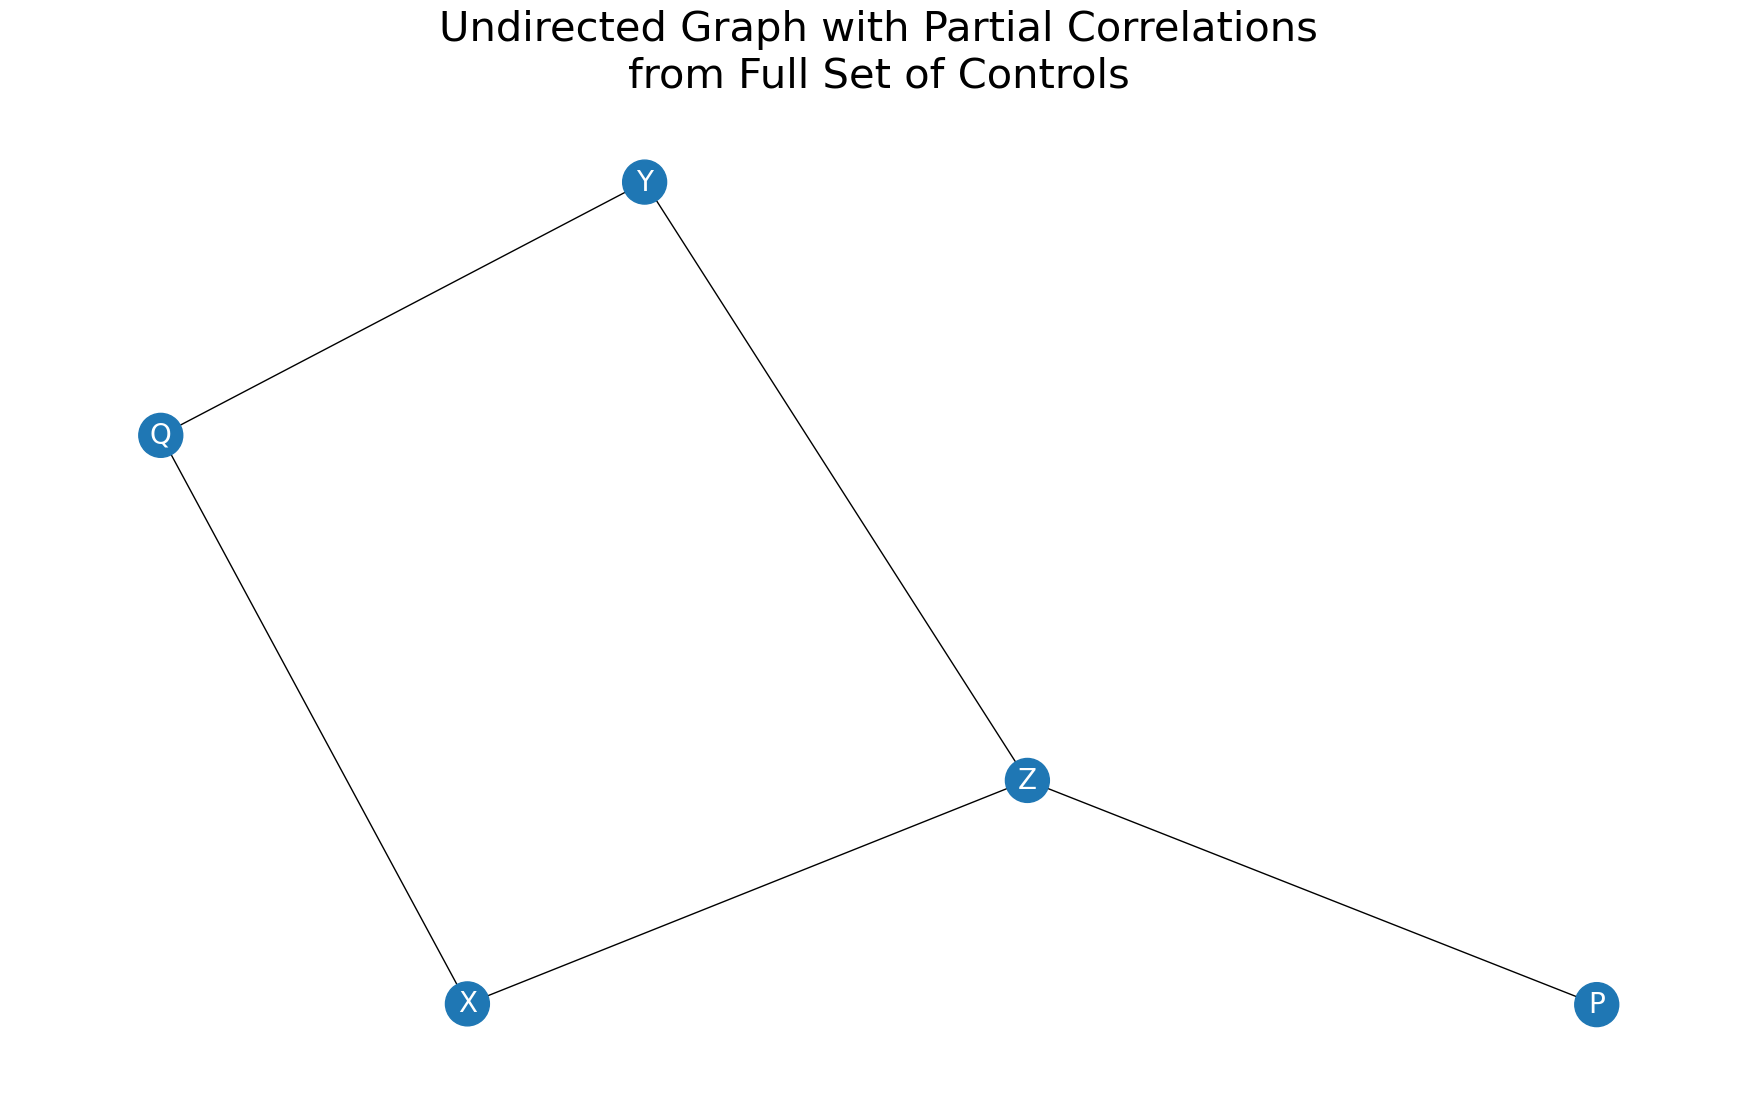

In [41]:
graph_DAG(undirected_graph, df, title = "Undirected Graph with Partial Correlations\nfrom Full Set of Controls")

# Estimating a Directed Acyclic Graph

Now that we have learned to generate the structure of an undirected graph, we have enough familiarity with the concept of a directed acyclc graph (DAG) that we can use the __*pgmpy*__ module to construct a graph with directed edges.\*

We will use the parallel PC algorithm to orient edges. No edge will be left undirected. 

\*A number of different algorithms are used to direct edges. For more information, see the script from [*pgmpy'*s PC algorithm module](https://github.com/pgmpy/pgmpy/blob/dev/pgmpy/estimators/PC.py).

In [42]:
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys()) - 2

model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


OutEdgeView([('Y', 'Z'), ('P', 'Z'), ('X', 'Z'), ('Q', 'Y'), ('Q', 'X')])

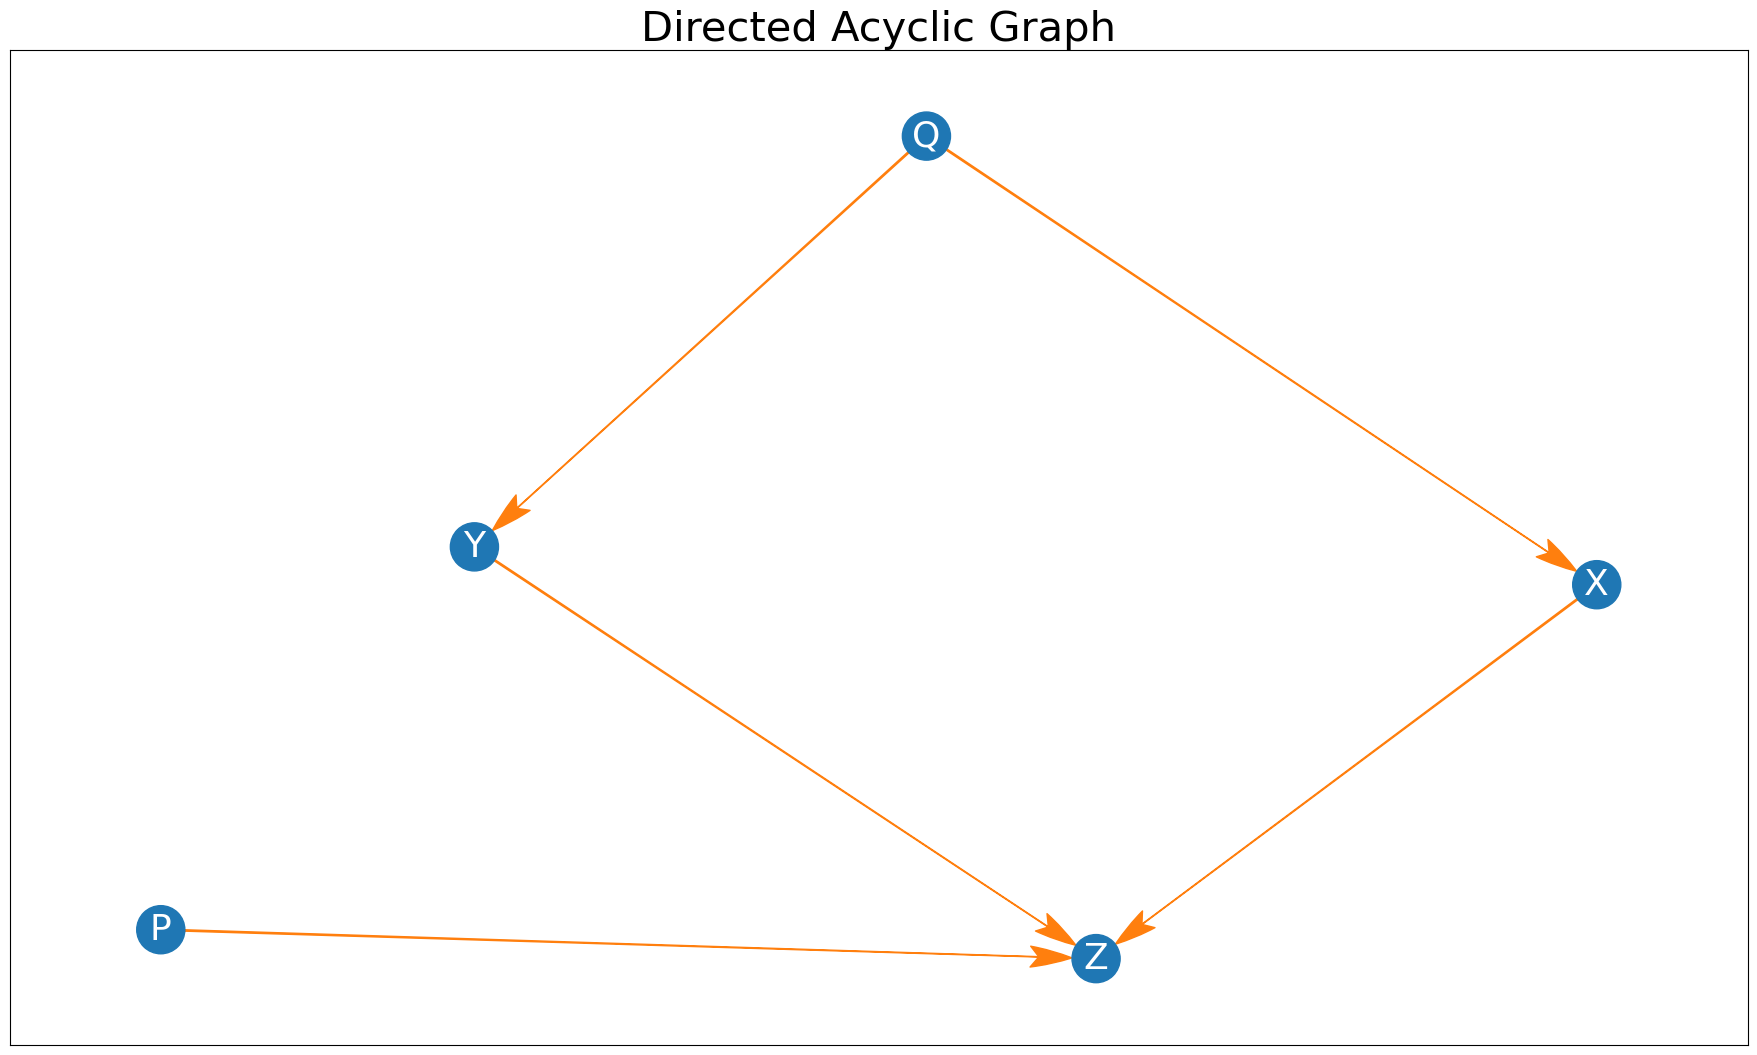

In [43]:

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

### D-separation

Finally, we should control for variables impacting the endogenous variable. For example, if we calculate the partial correlation of $X$ and $Z$ controlling for $Y$, perhaps attempting to estimate the impact of $X$ on $Z$ as defined by $P(Z|X=x, Y)$, we will succeed in removing influence from confound effects of $Q$ on our estimate. An easy way to do this is to identify which node in a pair is a sink node, and to control for all other nodes that directly influence that sink node. If there is no confounding effect from the control, their should be no statisically significan influence on the estimate of the partial correlation. But if the control is influenced by a confounder or is itself a confounder, than controlling for this variable fulfills the requirement of d-separation and the partial correlation should be accurate. Likewise, we do not want to control for variables that do no have influence on the sink-node. For example, it is sufficient to estimate the correlation of $Q$ and $X$ without controlling for any other variables. The estimate is signicantly larger than the partial correlation estimated in the undirected graph.

This exemplifies a problem that commonly arises with the employment of OLS regressions. The addition of exogenous variables to explain the value of a dependent variable can lead to erroneous estimation of marginal effects. As you can see from the distinction between the partial correlations in included in the graphical skeleton as compared to the partial correlations included in the DAG, the effects of $Q$ on $X$ and $Y$ are under estimated due to the inclusion of $Z$. Neither should P be included in this estimation, though its independence from $Q$ should limit its impact on estimation partial correlations of $QX$ and $QY$. We may also note the the partial correlation of $PZ$ is essentially uneffected by inclusion of the other variables since the value of $P$ is generated independently of the remaining variables in the graph. 

keep control: P
keep control: X
('Y', 'Z') ['P', 'X']
keep control: Y
keep control: X
('P', 'Z') ['Y', 'X']
keep control: P
keep control: Y
('X', 'Z') ['P', 'Y']
('Q', 'Y') []
('Q', 'X') []


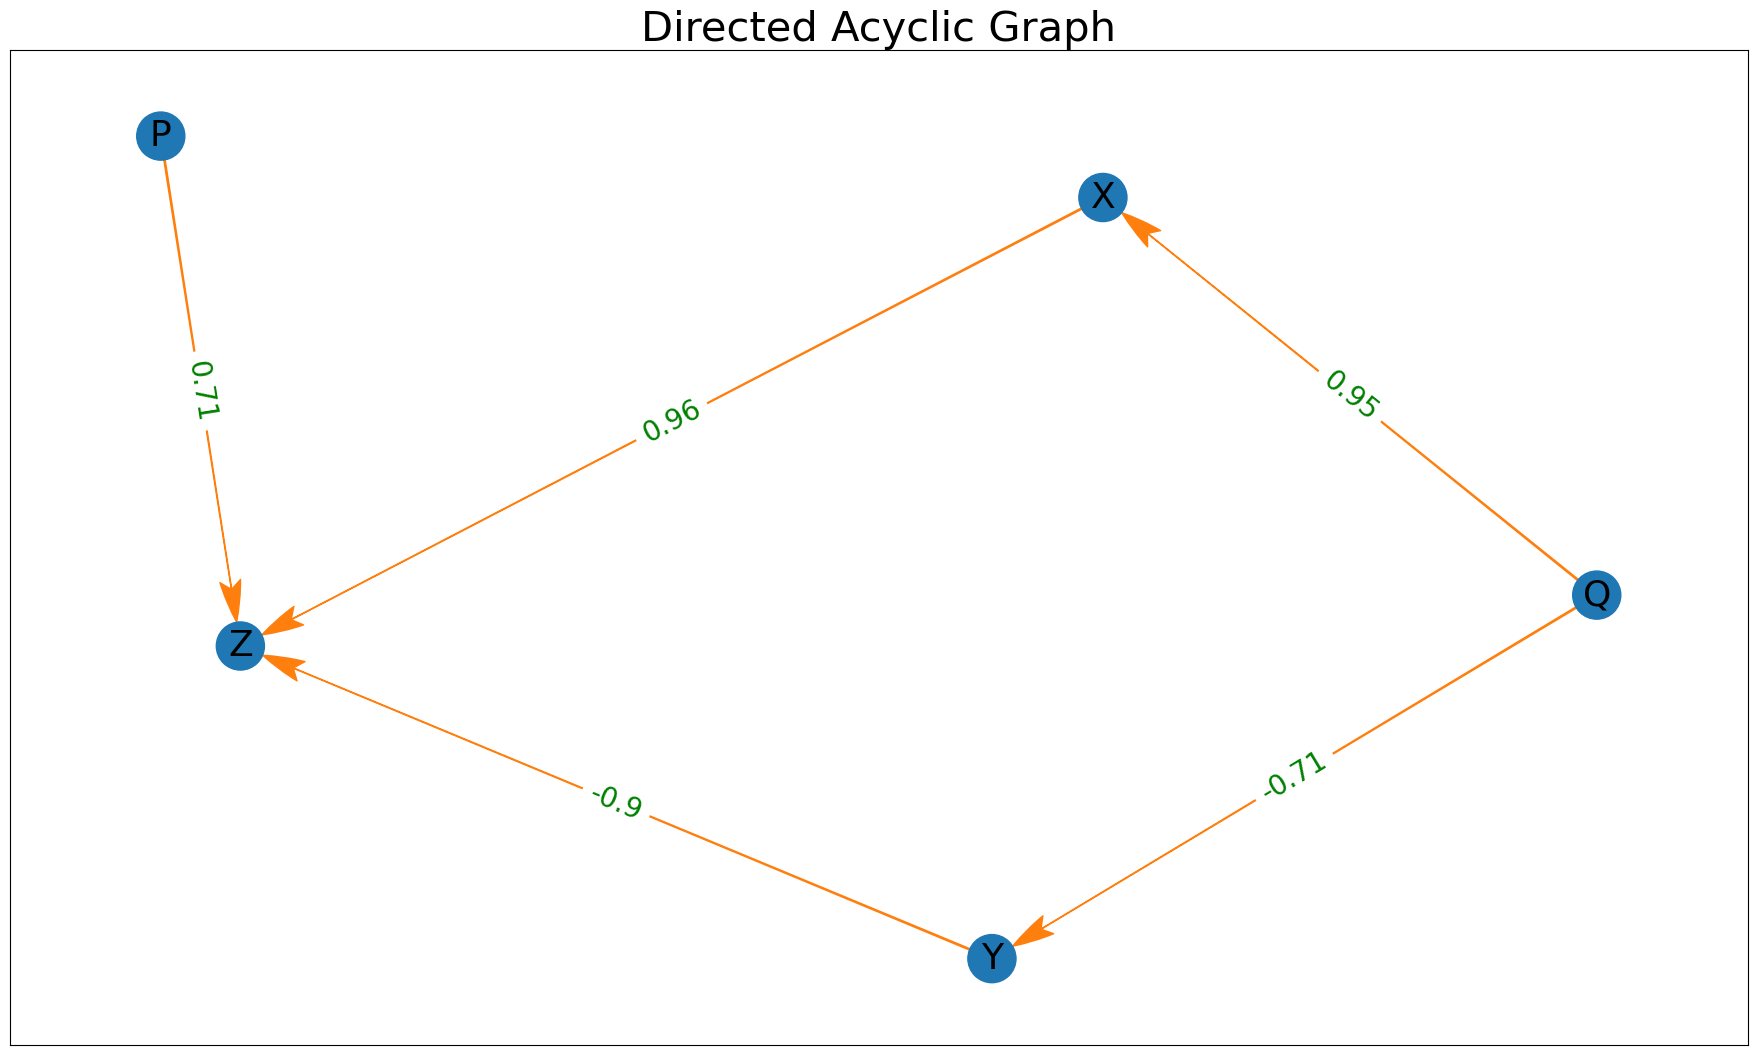

In [44]:
def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")


# Homework
1. Create a graphical skeleton like the one created above using the Economic Freedom of the World Index and Real GDP. 
2. Create a directed acyclic graph using the same data. Include partial correlations as explained in the **D-Separation** section.